# 1. Differential expression with **pydeseq2**
___
Дифференциальная экспрессия на пакете **pydeseq2**

This package is a python implementation of the DESeq2 method for differential expression analysis (DEA) with bulk RNA-seq data, originally in R. It aims to facilitate DEA experiments for python users.

As PyDESeq2 is a re-implementation of DESeq2 from scratch, you may experience some differences in terms of retrieved values or available features.

Currently, available features broadly correspond to the default settings of DESeq2 (v1.34.0) for single-factor and paired multi-factor analysis (with categorical factors), but it is planned to implement more in the future. In case there is a feature you would particularly like to be implemented, feel free to open an issue.

>GitHub: [link](https://github.com/owkin/PyDESeq2) <br>
Publication: "Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2." [Genome biology, 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)


## Import necessary libraries
___
*Подгрузим необходимые библиотеки*

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
!pip install GEOparse
import GEOparse, re, io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.5/278.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GEOparse: filename=GEOparse-2.0.3-py3-none-any.whl size=29047 sha256=be7bcf9a2751c5790b31d0dc1a14072e3dd40782f35b71f605ffd38a3b1fc9e7
  Stored in directory: /root/.cache/pip/wheels/14/96/7a/2ccb3a2a9e6f57b1c758b4ced8445fad36bba011bcebb2775f
Successfully built GEOparse


### Run and Hide
Here we are downloading pydeseq2 module. Run the following cell and hide after.

---

Скачиваем пакет pudeseq2. Запусти и после сверни ячейку ниже (Просто очень много кода. Можно его не читать)

~ 3 минуты

In [3]:
!pip install anndata==0.8.0
!pip install decoupler==1.3.4
!pip install omnipath==1.0.6
!pip install liana==0.1.8
!pip install stringdb==0.1.5
!git clone https://github.com/owkin/PyDESeq2.git

import decoupler
import omnipath
import liana
import stringdb

#dds.py
import time
import warnings
from typing import List
from typing import Tuple
from typing import Optional
from typing import Union
from typing import cast

import anndata as ad  # type: ignore
import numpy as np
import pandas as pd
import statsmodels.api as sm  # type: ignore
from joblib import Parallel  # type: ignore
from joblib import delayed
from joblib import parallel_backend
from scipy.special import polygamma  # type: ignore
from scipy.stats import f  # type: ignore
from scipy.stats import norm
from statsmodels.tools.sm_exceptions import DomainWarning  # type: ignore

# Ignore DomainWarning raised by statsmodels when fitting a Gamma GLM with identity link.
warnings.simplefilter("ignore", DomainWarning)
# Ignore AnnData's FutureWarning about implicit data conversion.
warnings.simplefilter("ignore", FutureWarning)

# TODO: support loading / saving DeseqDataSets from AnnData objects.


class DeseqDataSet(ad.AnnData):
    r"""A class to implement dispersion and log fold-change (LFC) estimation.

    The DeseqDataSet extends the `AnnData class
    <https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html#anndata.AnnData>`_.
    As such, it implements the same methods and attributes, in addition to those that are
    specific to pydeseq2.
    Dispersions and LFCs are estimated following the DESeq2 pipeline
    :cite:p:`DeseqDataSet-love2014moderated`.

    Parameters
    ----------
    counts : pandas.DataFrame
        Raw counts. One column per gene, rows are indexed by sample barcodes.

    clinical : pandas.DataFrame
        DataFrame containing clinical information.
        Must be indexed by sample barcodes.

    design_factors : str or list
        Name of the columns of clinical to be used as design variables. If a list,
        the last factor will be considered the variable of interest by default.
        Only bi-level factors are supported. (default: ``'condition'``).

    reference_level : str
        The factor to use as a reference. Must be one of the values taken by the design.
        If None, the reference will be chosen alphabetically (last in order).
        (default: ``None``).

    min_mu : float
        Threshold for mean estimates. (default: ``0.5``).

    min_disp : float
        Lower threshold for dispersion parameters. (default: ``1e-8``).

    max_disp : float
        Upper threshold for dispersion parameters.
        NB: The threshold that is actually enforced is max(max_disp, len(counts)).
        (default: ``10``).

    refit_cooks : bool
        Whether to refit cooks outliers. (default: ``True``).

    min_replicates : int
        Minimum number of replicates a condition should have
        to allow refitting its samples. (default: ``7``).

    beta_tol : float
        Stopping criterion for IRWLS. (default: ``1e-8``).

        .. math:: \vert dev_t - dev_{t+1}\vert / (\vert dev \vert + 0.1) < \beta_{tol}.

    n_cpus : int
        Number of cpus to use. If None, all available cpus will be used.
        (default: ``None``).

    batch_size : int
        Number of tasks to allocate to each joblib parallel worker. (default: ``128``).

    joblib_verbosity : int
        The verbosity level for joblib tasks. The higher the value, the more updates
        are reported. (default: ``0``).

    Attributes
    ----------
    X
        A ‘number of samples’ x ‘number of genes’ count data matrix.

    obs
        Key-indexed one-dimensional observations annotation of length 'number of
        samples". Used to store design factors.

    var
        Key-indexed one-dimensional gene-level annotation of length ‘number of genes’.

    uns
        Key-indexed unstructured annotation.

    obsm
        Key-indexed multi-dimensional observations annotation of length
        ‘number of samples’. Stores "design_matrix" and "size_factors", among others.

    varm
        Key-indexed multi-dimensional gene annotation of length ‘number of genes’.
        Stores "dispersions" and "LFC", among others.

    layers
        Key-indexed multi-dimensional arrays aligned to dimensions of `X`, e.g. "cooks".

    n_processes : int
        Number of cpus to use for multiprocessing.

    non_zero_idx : ndarray
        Indices of genes that have non-uniformly zero counts.

    non_zero_genes : pandas.Index
        Index of genes that have non-uniformly zero counts.

    counts_to_refit : anndata.AnnData
        Read counts after replacement, containing only genes
        for which dispersions and LFCs must be fitted again.

    new_all_zeroes_genes : pandas.Index
        Genes which have only zero counts after outlier replacement.

    References
    ----------
    .. bibliography::
        :keyprefix: DeseqDataSet-
    """

    def __init__(
        self,
        counts: pd.DataFrame,
        clinical: pd.DataFrame,
        design_factors: Union[str, List[str]] = "condition",
        reference_level: Optional[str] = None,
        min_mu: float = 0.5,
        min_disp: float = 1e-8,
        max_disp: float = 10.0,
        refit_cooks: bool = True,
        min_replicates: int = 7,
        beta_tol: float = 1e-8,
        n_cpus: Optional[int] = None,
        batch_size: int = 128,
        joblib_verbosity: int = 0,
    ) -> None:

        # Test counts before going further
        test_valid_counts(counts)

        # Initialize the AnnData part
        super().__init__(X=counts, obs=clinical, dtype=int)

        # Convert design_factors to list if a single string was provided.
        self.design_factors = (
            [design_factors] if isinstance(design_factors, str) else design_factors
        )
        if self.obs[self.design_factors].isna().any().any():
            raise ValueError("NaNs are not allowed in the design factors.")
        self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)

        # Build the design matrix
        # Stored in the obsm attribute of the dataset
        self.obsm["design_matrix"] = build_design_matrix(
            clinical_df=self.obs,
            design_factors=self.design_factors,
            ref=reference_level,
            expanded=False,
            intercept=True,
        )

        self.min_mu = min_mu
        self.min_disp = min_disp
        self.max_disp = np.maximum(max_disp, self.n_obs)
        self.refit_cooks = refit_cooks
        self.min_replicates = min_replicates
        self.beta_tol = beta_tol
        self.n_processes = get_num_processes(n_cpus)
        self.batch_size = batch_size
        self.joblib_verbosity = joblib_verbosity

    def deseq2(self) -> None:
        """Perform dispersion and log fold-change (LFC) estimation.

        Wrapper for the first part of the PyDESeq2 pipeline.
        """

        # Compute DESeq2 normalization factors using the Median-of-ratios method
        self.fit_size_factors()
        # Fit an independent negative binomial model per gene
        self.fit_genewise_dispersions()
        # Fit a parameterized trend curve for dispersions, of the form
        # f(\mu) = \alpha_1/\mu + a_0
        self.fit_dispersion_trend()
        # Compute prior dispersion variance
        self.fit_dispersion_prior()
        # Refit genewise dispersions a posteriori (shrinks estimates towards trend curve)
        self.fit_MAP_dispersions()
        # Fit log-fold changes (in natural log scale)
        self.fit_LFC()
        # Compute Cooks distances to find outliers
        self.calculate_cooks()

        if self.refit_cooks:
            # Replace outlier counts, and refit dispersions and LFCs
            # for genes that had outliers replaced
            self.refit()

    def fit_size_factors(self) -> None:
        """Fit sample-wise deseq2 normalization (size) factors.

        Uses the median-of-ratios method: see :func:`pydeseq2.preprocessing.deseq2_norm`.
        """
        print("Fitting size factors...")
        start = time.time()
        self.layers["normed_counts"], self.obsm["size_factors"] = deseq2_norm(self.X)
        end = time.time()
        print(f"... done in {end - start:.2f} seconds.\n")

    def fit_genewise_dispersions(self) -> None:
        """Fit gene-wise dispersion estimates.

        Fits a negative binomial per gene, independently.
        """
        # Check that size factors are available. If not, compute them.
        if "size_factors" not in self.obsm:
            self.fit_size_factors()

        # Exclude genes with all zeroes
        self.varm["non_zero"] = ~(self.X == 0).all(axis=0)
        self.non_zero_idx = np.arange(self.n_vars)[self.varm["non_zero"]]
        self.non_zero_genes = self.var_names[self.varm["non_zero"]]

        if isinstance(self.non_zero_genes, pd.MultiIndex):
            raise ValueError("non_zero_genes should not be a MultiIndex")

        # Fit "method of moments" dispersion estimates
        self._fit_MoM_dispersions()

        # Convert design_matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values

        # mu_hat is initialized differently depending on the number of different factor
        # groups. If there are as many different factor combinations as design factors
        # (intercept included), it is fitted with a linear model, otherwise it is fitted
        # with a GLM (using rough dispersion estimates).
        if (
            len(self.obsm["design_matrix"].value_counts())
            == self.obsm["design_matrix"].shape[-1]
        ):
            with parallel_backend("loky", inner_max_num_threads=1):
                mu_hat_ = np.array(
                    Parallel(
                        n_jobs=self.n_processes,
                        verbose=self.joblib_verbosity,
                        batch_size=self.batch_size,
                    )(
                        delayed(fit_lin_mu)(
                            counts=self.X[:, i],
                            size_factors=self.obsm["size_factors"],
                            design_matrix=design_matrix,
                            min_mu=self.min_mu,
                        )
                        for i in self.non_zero_idx
                    )
                )
        else:
            with parallel_backend("loky", inner_max_num_threads=1):
                res = Parallel(
                    n_jobs=self.n_processes,
                    verbose=self.joblib_verbosity,
                    batch_size=self.batch_size,
                )(
                    delayed(irls_solver)(
                        counts=self.X[:, i],
                        size_factors=self.obsm["size_factors"],
                        design_matrix=design_matrix,
                        disp=self.varm["_rough_dispersions"][i],
                        min_mu=self.min_mu,
                        beta_tol=self.beta_tol,
                    )
                    for i in self.non_zero_idx
                )

                _, mu_hat_, _, _ = zip(*res)
                mu_hat_ = np.array(mu_hat_)

        self.layers["_mu_hat"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_mu_hat"][:, self.varm["non_zero"]] = mu_hat_.T

        print("Fitting dispersions...")
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(fit_alpha_mle)(
                    counts=self.X[:, i],
                    design_matrix=design_matrix,
                    mu=self.layers["_mu_hat"][:, i],
                    alpha_hat=self.varm["_rough_dispersions"][i],
                    min_disp=self.min_disp,
                    max_disp=self.max_disp,
                )
                # for i in range(num_genes)
                for i in self.non_zero_idx
            )
        end = time.time()
        print(f"... done in {end - start:.2f} seconds.\n")

        dispersions_, l_bfgs_b_converged_ = zip(*res)

        self.varm["genewise_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["genewise_dispersions"][self.varm["non_zero"]] = np.clip(
            dispersions_, self.min_disp, self.max_disp
        )

        self.varm["_genewise_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_genewise_converged"][self.varm["non_zero"]] = l_bfgs_b_converged_

    def fit_dispersion_trend(self) -> None:
        r"""Fit the dispersion trend coefficients.

        :math:`f(\mu) = \alpha_1/\mu + a_0`.
        """

        # Check that genewise dispersions are available. If not, compute them.
        if "genewise_dispersions" not in self.varm:
            self.fit_genewise_dispersions()

        print("Fitting dispersion trend curve...")
        start = time.time()
        self.varm["_normed_means"] = self.layers["normed_counts"].mean(0)

        # Exclude all-zero counts
        targets = pd.Series(
            self[:, self.non_zero_genes].varm["genewise_dispersions"].copy(),
            index=self.non_zero_genes,
        )
        covariates = sm.add_constant(
            pd.Series(
                1 / self[:, self.non_zero_genes].varm["_normed_means"],
                index=self.non_zero_genes,
            )
        )

        for gene in self.non_zero_genes:
            if (
                np.isinf(covariates.loc[gene]).any()
                or np.isnan(covariates.loc[gene]).any()
            ):
                targets.drop(labels=[gene], inplace=True)
                covariates.drop(labels=[gene], inplace=True)

        # Initialize coefficients
        old_coeffs = pd.Series([0.1, 0.1])
        coeffs = pd.Series([1.0, 1.0])

        while (np.log(np.abs(coeffs / old_coeffs)) ** 2).sum() >= 1e-6:
            glm_gamma = sm.GLM(
                targets.values,
                covariates.values,
                family=sm.families.Gamma(link=sm.families.links.identity()),
            )

            res = glm_gamma.fit()
            old_coeffs = coeffs.copy()
            coeffs = res.params

            # Filter out genes that are too far away from the curve before refitting
            predictions = covariates.values @ coeffs
            pred_ratios = (
                self[:, covariates.index].varm["genewise_dispersions"] / predictions
            )

            targets.drop(
                targets[(pred_ratios < 1e-4) | (pred_ratios >= 15)].index,
                inplace=True,
            )
            covariates.drop(
                covariates[(pred_ratios < 1e-4) | (pred_ratios >= 15)].index,
                inplace=True,
            )

        end = time.time()
        print(f"... done in {end - start:.2f} seconds.\n")

        self.uns["trend_coeffs"] = pd.Series(coeffs, index=["a0", "a1"])

        self.varm["fitted_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["fitted_dispersions"][self.varm["non_zero"]] = dispersion_trend(
            self.varm["_normed_means"][self.varm["non_zero"]],
            self.uns["trend_coeffs"],
        )

    def fit_dispersion_prior(self) -> None:
        """Fit dispersion variance priors and standard deviation of log-residuals.

        The computation is based on genes whose dispersions are above 100 * min_disp.
        """

        # Check that the dispersion trend curve was fitted. If not, fit it.
        if "trend_coeffs" not in self.uns:
            self.fit_dispersion_trend()

        # Exclude genes with all zeroes
        num_genes = len(self.non_zero_genes)
        num_vars = self.obsm["design_matrix"].shape[-1]

        # Fit dispersions to the curve, and compute log residuals
        disp_residuals = np.log(
            self[:, self.non_zero_genes].varm["genewise_dispersions"]
        ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])

        # Compute squared log-residuals and prior variance based on genes whose
        # dispersions are above 100 * min_disp. This is to reproduce DESeq2's behaviour.
        above_min_disp = self[:, self.non_zero_genes].varm["genewise_dispersions"] >= (
            100 * self.min_disp
        )

        self.uns["_squared_logres"] = np.median(
            np.abs(disp_residuals[above_min_disp])
        ) ** 2 / norm.ppf(0.75)
        self.uns["prior_disp_var"] = np.maximum(
            self.uns["_squared_logres"] - polygamma(1, (num_genes - num_vars) / 2),
            0.25,
        )

    def fit_MAP_dispersions(self) -> None:
        """Fit Maximum a Posteriori dispersion estimates.

        After MAP dispersions are fit, filter genes for which we don't apply shrinkage.
        """

        # Check that the dispersion prior variance is available. If not, compute it.
        if "prior_disp_var" not in self.uns:
            self.fit_dispersion_prior()

        # Convert design matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values

        print("Fitting MAP dispersions...")
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(fit_alpha_mle)(
                    counts=self.X[:, i],
                    design_matrix=design_matrix,
                    mu=self.layers["_mu_hat"][:, i],
                    alpha_hat=self.varm["fitted_dispersions"][i],
                    min_disp=self.min_disp,
                    max_disp=self.max_disp,
                    prior_disp_var=self.uns["prior_disp_var"].item(),
                    cr_reg=True,
                    prior_reg=True,
                )
                for i in self.non_zero_idx
            )
        end = time.time()
        print(f"... done in {end-start:.2f} seconds.\n")

        dispersions_, l_bfgs_b_converged_ = zip(*res)

        self.varm["MAP_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["MAP_dispersions"][self.varm["non_zero"]] = np.clip(
            dispersions_, self.min_disp, self.max_disp
        )

        self.varm["_MAP_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_MAP_converged"][self.varm["non_zero"]] = l_bfgs_b_converged_

        # Filter outlier genes for which we won't apply shrinkage
        self.varm["dispersions"] = self.varm["MAP_dispersions"].copy()
        self.varm["_outlier_genes"] = np.log(self.varm["dispersions"]) > np.log(
            self.varm["fitted_dispersions"]
        ) + 2 * np.sqrt(self.uns["_squared_logres"])
        self.varm["dispersions"][self.varm["_outlier_genes"]] = self.varm[
            "genewise_dispersions"
        ][self.varm["_outlier_genes"]]

    def fit_LFC(self) -> None:
        """Fit log fold change (LFC) coefficients.

        In the 2-level setting, the intercept corresponds to the base mean,
        while the second is the actual LFC coefficient, in natural log scale.
        """

        # Check that MAP dispersions are available. If not, compute them.
        if "dispersions" not in self.varm:
            self.fit_MAP_dispersions()

        # Convert design matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values

        print("Fitting LFCs...")
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(irls_solver)(
                    counts=self.X[:, i],
                    size_factors=self.obsm["size_factors"],
                    design_matrix=design_matrix,
                    disp=self.varm["dispersions"][i],
                    min_mu=self.min_mu,
                    beta_tol=self.beta_tol,
                )
                for i in self.non_zero_idx
            )
        end = time.time()
        print(f"... done in {end-start:.2f} seconds.\n")

        MLE_lfcs_, mu_, hat_diagonals_, converged_ = zip(*res)
        mu_ = np.array(mu_).T
        hat_diagonals_ = np.array(hat_diagonals_).T

        self.varm["LFC"] = pd.DataFrame(
            np.NaN,
            index=self.var_names,
            columns=self.obsm["design_matrix"].columns,
        )

        self.varm["LFC"].update(
            pd.DataFrame(
                MLE_lfcs_,
                index=self.non_zero_genes,
                columns=self.obsm["design_matrix"].columns,
            )
        )

        self.layers["_mu_LFC"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_mu_LFC"][:, self.varm["non_zero"]] = mu_

        self.layers["_hat_diagonals"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_hat_diagonals"][:, self.varm["non_zero"]] = hat_diagonals_

        self.varm["_LFC_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_LFC_converged"][self.varm["non_zero"]] = converged_

    def calculate_cooks(self) -> None:
        """Compute Cook's distance for outlier detection.

        Measures the contribution of a single entry to the output of LFC estimation.
        """

        # Check that MAP dispersions are available. If not, compute them.
        if "dispersions" not in self.varm:
            self.fit_MAP_dispersions()

        num_vars = self.obsm["design_matrix"].shape[-1]

        # Keep only non-zero genes
        nonzero_data = self[:, self.non_zero_genes]
        normed_counts = pd.DataFrame(
            nonzero_data.X / self.obsm["size_factors"][:, None],
            index=self.obs_names,
            columns=self.non_zero_genes,
        )

        dispersions = robust_method_of_moments_disp(
            normed_counts, self.obsm["design_matrix"]
        )

        V = (
            nonzero_data.layers["_mu_LFC"]
            + dispersions.values[None, :] * nonzero_data.layers["_mu_LFC"] ** 2
        )
        squared_pearson_res = (nonzero_data.X - nonzero_data.layers["_mu_LFC"]) ** 2 / V
        diag_mul = (
            nonzero_data.layers["_hat_diagonals"]
            / (1 - nonzero_data.layers["_hat_diagonals"]) ** 2
        )

        self.layers["cooks"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["cooks"][:, self.varm["non_zero"]] = (
            squared_pearson_res / num_vars * diag_mul
        )

    def refit(self) -> None:
        """Refit Cook outliers.

        Replace values that are filtered out based on the Cooks distance with imputed
        values, and then re-run the whole DESeq2 pipeline on replaced values.
        """
        # Replace outlier counts
        self._replace_outliers()
        print(f"Refitting {sum(self.varm['replaced']) } outliers.\n")

        if sum(self.varm["replaced"]) > 0:
            # Refit dispersions and LFCs for genes that had outliers replaced
            self._refit_without_outliers()

    def _fit_MoM_dispersions(self) -> None:
        """ "Rough method of moments" initial dispersions fit.
        Estimates are the max of "robust" and "method of moments" estimates.
        """

        # Check that size_factors are available. If not, compute them.
        if "size_factors" not in self.obsm:
            self.fit_size_factors()

        rde = fit_rough_dispersions(
            self.X,
            self.obsm["size_factors"],
            self.obsm["design_matrix"],
        )
        mde = fit_moments_dispersions(self.X, self.obsm["size_factors"])
        alpha_hat = np.minimum(rde, mde)

        self.varm["_rough_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["_rough_dispersions"][self.varm["non_zero"]] = np.clip(
            alpha_hat, self.min_disp, self.max_disp
        )

    def _replace_outliers(self) -> None:
        """Replace values that are filtered out based
        on the Cooks distance with imputed values.
        """

        # Check that cooks distances are available. If not, compute them.
        if "cooks" not in self.layers:
            self.calculate_cooks()

        num_samples = self.n_obs
        num_vars = self.obsm["design_matrix"].shape[1]

        # Check whether cohorts have enough samples to allow refitting
        n_or_more = (
            self.obsm["design_matrix"][
                self.obsm["design_matrix"].columns[-1]
            ].value_counts()
            >= self.min_replicates
        )

        if n_or_more.sum() == 0:
            # No sample can be replaced. Set self.replaced to False and exit.
            self.varm["replaced"] = pd.Series(False, index=self.var_names)
            return

        replaceable = n_or_more[
            self.obsm["design_matrix"][self.obsm["design_matrix"].columns[-1]]
        ]

        self.obsm["replaceable"] = replaceable.values

        # Get positions of counts with cooks above threshold
        cooks_cutoff = f.ppf(0.99, num_vars, num_samples - num_vars)
        idx = self.layers["cooks"] > cooks_cutoff
        self.varm["replaced"] = idx.any(axis=0)

        # Compute replacement counts: trimmed means * size_factors
        self.counts_to_refit = self[:, self.varm["replaced"]].copy()

        trim_base_mean = pd.DataFrame(
            cast(
                np.ndarray,
                trimmed_mean(
                    self.counts_to_refit.X / self.obsm["size_factors"][:, None],
                    trim=0.2,
                    axis=0,
                ),
            ),
            index=self.counts_to_refit.var_names,
        )

        replacement_counts = (
            pd.DataFrame(
                trim_base_mean.values * self.obsm["size_factors"],
                index=self.counts_to_refit.var_names,
                columns=self.counts_to_refit.obs_names,
            )
            .astype(int)
            .T
        )

        if sum(self.varm["replaced"] > 0):
            self.counts_to_refit.X[
                self.obsm["replaceable"][:, None] & idx[:, self.varm["replaced"]]
            ] = replacement_counts.values[
                self.obsm["replaceable"][:, None] & idx[:, self.varm["replaced"]]
            ]

    def _refit_without_outliers(
        self,
    ) -> None:
        """Re-run the whole DESeq2 pipeline with replaced outliers."""
        assert (
            self.refit_cooks
        ), "Trying to refit Cooks outliers but the 'refit_cooks' flag is set to False"

        # Check that replaced counts are available. If not, compute them.
        if not hasattr(self, "counts_to_refit"):
            self._replace_outliers()

        # Only refit genes for which replacing outliers hasn't resulted in all zeroes
        new_all_zeroes = (self.counts_to_refit.X == 0).all(axis=0)
        self.new_all_zeroes_genes = self.counts_to_refit.var_names[new_all_zeroes]
        self.counts_to_refit = self.counts_to_refit[:, ~new_all_zeroes].copy()

        if isinstance(self.new_all_zeroes_genes, pd.MultiIndex):
            raise ValueError

        sub_dds = DeseqDataSet(
            counts=pd.DataFrame(
                self.counts_to_refit.X,
                index=self.counts_to_refit.obs_names,
                columns=self.counts_to_refit.var_names,
            ),
            clinical=self.obs,
            design_factors=self.design_factors,
            min_mu=self.min_mu,
            min_disp=self.min_disp,
            max_disp=self.max_disp,
            refit_cooks=self.refit_cooks,
            min_replicates=self.min_replicates,
            beta_tol=self.beta_tol,
            n_cpus=self.n_processes,
            batch_size=self.batch_size,
        )

        # Use the same size factors
        sub_dds.obsm["size_factors"] = self.counts_to_refit.obsm["size_factors"]

        # Estimate gene-wise dispersions.
        sub_dds.fit_genewise_dispersions()

        # Compute trend dispersions.
        # Note: the trend curve is not refitted.
        sub_dds.uns["trend_coeffs"] = self.uns["trend_coeffs"]
        sub_dds.varm["_normed_means"] = (
            self.counts_to_refit.X / self.counts_to_refit.obsm["size_factors"][:, None]
        ).mean(0)
        sub_dds.varm["fitted_dispersions"] = dispersion_trend(
            sub_dds.varm["_normed_means"],
            sub_dds.uns["trend_coeffs"],
        )

        # Estimate MAP dispersions.
        # Note: the prior variance is not recomputed.
        sub_dds.uns["_squared_logres"] = self.uns["_squared_logres"]
        sub_dds.uns["prior_disp_var"] = self.uns["prior_disp_var"]

        sub_dds.fit_MAP_dispersions()

        # Estimate log-fold changes (in natural log scale)
        sub_dds.fit_LFC()

        # Replace values in main object
        to_replace = self.varm["replaced"].copy()
        # Only replace if genes are not all zeroes after outlier replacement
        to_replace[to_replace] = ~new_all_zeroes

        self.varm["_normed_means"][to_replace] = sub_dds.varm["_normed_means"]
        self.varm["LFC"][to_replace] = sub_dds.varm["LFC"]
        self.varm["dispersions"][to_replace] = sub_dds.varm["dispersions"]

        replace_cooks = pd.DataFrame(self.layers["cooks"].copy())
        replace_cooks.loc[self.obsm["replaceable"], to_replace] = 0.0

        self.layers["replace_cooks"] = replace_cooks
        # Take into account new all-zero genes
        self[:, self.new_all_zeroes_genes].varm["_normed_means"] = np.zeros(
            new_all_zeroes.sum()
        )
        self[:, self.new_all_zeroes_genes].varm["LFC"] = np.zeros(new_all_zeroes.sum())

#ds.py
import time
from typing import List
from typing import Optional
from typing import cast

import statsmodels.api as sm  # type: ignore
from IPython.display import display  # type: ignore
from joblib import Parallel  # type: ignore
from joblib import delayed  # type: ignore
from joblib import parallel_backend  # type: ignore
from scipy.optimize import root_scalar  # type: ignore
from scipy.stats import f  # type: ignore
from statsmodels.stats.multitest import multipletests  # type: ignore

class DeseqStats:
    """PyDESeq2 statistical tests for differential expression.

    Implements p-value estimation for differential gene expression according
    to the DESeq2 pipeline :cite:p:`DeseqStats-love2014moderated`.

    Also supports apeGLM log-fold change shrinkage :cite:p:`DeseqStats-zhu2019heavy`.

    Parameters
    ----------
    dds : DeseqDataSet
        DeseqDataSet for which dispersion and LFCs were already estimated.

    contrast : list or None
        A list of three strings, in the following format:
        ``['variable_of_interest', 'tested_level', 'reference_level']``.
        Names must correspond to the clinical data passed to the DeseqDataSet.
        E.g., ``['condition', 'B', 'A']`` will measure the LFC of 'condition B' compared
        to 'condition A'. If None, the last variable from the design matrix is chosen
        as the variable of interest, and the reference level is picked alphabetically.
        (default: ``None``).

    alpha : float
        P-value and adjusted p-value significance threshold (usually 0.05).
        (default: ``0.05``).

    cooks_filter : bool
        Whether to filter p-values based on cooks outliers. (default: ``True``).

    independent_filter : bool
        Whether to perform independent filtering to correct p-value trends.
        (default: ``True``).

    n_cpus : int
        Number of cpus to use for multiprocessing.
        If None, all available CPUs will be used. (default: ``None``).

    prior_LFC_var : ndarray
        Prior variance for LFCs, used for ridge regularization. (default: ``None``).

    batch_size : int
        Number of tasks to allocate to each joblib parallel worker. (default: ``128``).

    joblib_verbosity : int
        The verbosity level for joblib tasks. The higher the value, the more updates
        are reported. (default: ``0``).

    Attributes
    ----------
    base_mean : pandas.Series
        Genewise means of normalized counts.

    contrast_idx : int
        Index of the LFC column corresponding to the variable being tested.

    design_matrix : pandas.DataFrame
        A DataFrame with experiment design information (to split cohorts).
        Indexed by sample barcodes. Depending on the contrast that is provided to the
        DeseqStats object, it may differ from the DeseqDataSet design matrix, as the
        reference level may need to be adapted.

    LFC : pandas.DataFrame
        Estimated log-fold change between conditions and intercept, in natural log scale.

    SE : pandas.Series
        Standard LFC error.

    statistics : pandas.Series
        Wald statistics.

    p_values : pandas.Series
        P-values estimated from Wald statistics.

    padj : pandas.Series
        P-values adjusted for multiple testing.

    results_df : pandas.DataFrame
        Summary of the statistical analysis.

    shrunk_LFCs : bool
        Whether LFCs are shrunk.

    n_processes : int
        Number of threads to use for multiprocessing.

    References
    ----------
    .. bibliography::
        :keyprefix: DeseqStats-
    """

    def __init__(
        self,
        dds: DeseqDataSet,
        contrast: Optional[List[str]] = None,
        alpha: float = 0.05,
        cooks_filter: bool = True,
        independent_filter: bool = True,
        n_cpus: Optional[int] = None,
        prior_LFC_var: Optional[np.ndarray] = None,
        batch_size: int = 128,
        joblib_verbosity: int = 0,
    ) -> None:
        assert (
            "LFC" in dds.varm
        ), "Please provide a fitted DeseqDataSet by first running the `deseq2` method."

        self.dds = dds

        if contrast is not None:  # Test contrast if provided
            assert len(contrast) == 3, "The contrast should contain three strings."
            assert (
                contrast[0] in self.dds.design_factors
            ), "The contrast variable should be one of the design factors."
            assert (
                contrast[1] in self.dds.obs[contrast[0]].values
                and contrast[2] in self.dds.obs[contrast[0]].values
            ), "The contrast levels should correspond to design factors levels."
            self.contrast = contrast
        else:  # Build contrast if None
            factor = self.dds.design_factors[-1]
            levels = np.unique(self.dds.obs[factor]).astype(str)
            if (
                "_".join([factor, levels[0]])
                == self.dds.obsm["design_matrix"].columns[-1]
            ):
                self.contrast = [factor, levels[0], levels[1]]
            else:
                self.contrast = [factor, levels[1], levels[0]]

        self.alpha = alpha
        self.cooks_filter = cooks_filter
        self.independent_filter = independent_filter
        self.prior_LFC_var = prior_LFC_var
        self.base_mean = self.dds.varm["_normed_means"].copy()

        # Initialize the design matrix and LFCs. If the chosen reference level are the
        # same as in dds, keep them unchanged. Otherwise, change reference level.
        self.design_matrix = self.dds.obsm["design_matrix"].copy()
        self.LFC = self.dds.varm["LFC"].copy()
        if self.contrast is None:
            alternative_level = self.dds.obsm["design_matrix"].columns[-1]
        else:
            alternative_level = "_".join([self.contrast[0], self.contrast[1]])

        if alternative_level in self.dds.obsm["design_matrix"].columns:
            self.contrast_idx = self.dds.varm["LFC"].columns.get_loc(alternative_level)
        else:  # The reference level is not the same as in dds: change it
            reference_level = "_".join([self.contrast[0], self.contrast[2]])
            self.contrast_idx = self.dds.varm["LFC"].columns.get_loc(reference_level)
            # Change the design matrix reference level
            self.design_matrix.rename(
                columns={
                    self.design_matrix.columns[self.contrast_idx]: alternative_level
                },
                inplace=True,
            )
            self.design_matrix.iloc[:, self.contrast_idx] = (
                1 - self.design_matrix.iloc[:, self.contrast_idx]
            )
            # Rename and update LFC coefficients accordingly
            self.LFC.rename(
                columns={self.LFC.columns[self.contrast_idx]: alternative_level},
                inplace=True,
            )
            self.LFC.iloc[:, 0] += self.LFC.iloc[:, self.contrast_idx]
            self.LFC.iloc[:, self.contrast_idx] *= -1
        # Set a flag to indicate that LFCs are unshrunk
        self.shrunk_LFCs = False
        self.n_processes = get_num_processes(n_cpus)
        self.batch_size = batch_size
        self.joblib_verbosity = joblib_verbosity

        # If the `refit_cooks` attribute of the dds object is True, check that outliers
        # were actually refitted.
        if self.dds.refit_cooks and "replaced" not in self.dds.varm:
            raise AttributeError(
                "dds has 'refit_cooks' set to True but Cooks outliers have not been "
                "refitted. Please run 'dds.refit()' first or set 'dds.refit_cooks' "
                "to False."
            )

    def summary(self) -> None:
        """Run the statistical analysis.

        The results are stored in the ``results_df`` attribute.
        """

        if not hasattr(self, "p_values"):
            # Estimate p-values with Wald test
            self.run_wald_test()

        if self.cooks_filter:
            # Filter p-values based on Cooks outliers
            self._cooks_filtering()

        if not hasattr(self, "padj"):
            if self.independent_filter:
                # Compute adjusted p-values and correct p-value trend
                self._independent_filtering()
            else:
                # Compute adjusted p-values using the Benjamini-Hochberg method, without
                # correcting the p-value trend.
                self._p_value_adjustment()

        # Store the results in a DataFrame, in log2 scale for LFCs.
        self.results_df = pd.DataFrame(index=self.dds.var_names)
        self.results_df["baseMean"] = self.base_mean
        self.results_df["log2FoldChange"] = self.LFC.iloc[:, self.contrast_idx] / np.log(
            2
        )
        self.results_df["lfcSE"] = self.SE / np.log(2)
        self.results_df["stat"] = self.statistics
        self.results_df["pvalue"] = self.p_values
        self.results_df["padj"] = self.padj

        print(
            f"Log2 fold change & Wald test p-value: "
            f"{self.contrast[0]} {self.contrast[1]} vs {self.contrast[2]}"
        )
        display(self.results_df)

    def run_wald_test(self) -> None:
        """Perform a Wald test.

        Get gene-wise p-values for gene over/under-expression.`
        """

        num_genes = self.dds.n_vars
        num_vars = self.design_matrix.shape[1]

        # Raise a warning if LFCs are shrunk.
        if self.shrunk_LFCs:
            print(
                "Note: running Wald test on shrunk LFCs. "
                "Some sequencing datasets show better performance with the testing "
                "separated from the use of the LFC prior."
            )

        mu = (
            np.exp(self.design_matrix @ self.LFC.T)
            .multiply(self.dds.obsm["size_factors"], 0)
            .values
        )

        # Set regularization factors.
        if self.prior_LFC_var is not None:
            ridge_factor = np.diag(1 / self.prior_LFC_var**2)
        else:
            ridge_factor = np.diag(np.repeat(1e-6, num_vars))

        design_matrix = self.design_matrix.values
        LFCs = self.LFC.values

        print("Running Wald tests...")
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(wald_test)(
                    design_matrix=design_matrix,
                    disp=self.dds.varm["dispersions"][i],
                    lfc=LFCs[i],
                    mu=mu[:, i],
                    ridge_factor=ridge_factor,
                    idx=self.contrast_idx,
                )
                for i in range(num_genes)
            )
        end = time.time()
        print(f"... done in {end-start:.2f} seconds.\n")

        pvals, stats, se = zip(*res)

        # need casting because mypy recognize them as TimeStampSeries
        # reason is unknown...
        self.p_values = cast(pd.Series, pd.Series(pvals, index=self.dds.var_names))
        self.statistics = cast(pd.Series, pd.Series(stats, index=self.dds.var_names))
        self.SE = cast(pd.Series, pd.Series(se, index=self.dds.var_names))

        # Account for possible all_zeroes due to outlier refitting in DESeqDataSet
        if self.dds.refit_cooks and self.dds.varm["replaced"].sum() > 0:
            self.SE.loc[self.dds.new_all_zeroes_genes] = 0.0
            self.statistics.loc[self.dds.new_all_zeroes_genes] = 0.0
            self.p_values.loc[self.dds.new_all_zeroes_genes] = 1.0

    def lfc_shrink(self) -> None:
        """LFC shrinkage with an apeGLM prior :cite:p:`DeseqStats-zhu2019heavy`.

        Shrinks LFCs using a heavy-tailed Cauchy prior, leaving p-values unchanged.

        Returns
        -------
        pandas.DataFrame or None
            If pvalues were already computed, return the results DataFrame with MAP LFCs,
            but unmodified stats and pvalues.
        """
        size = 1.0 / self.dds.varm["dispersions"]
        offset = np.log(self.dds.obsm["size_factors"])

        # Set priors
        prior_no_shrink_scale = 15
        prior_var = self._fit_prior_var()
        prior_scale = np.minimum(np.sqrt(prior_var), 1)

        design_matrix = self.design_matrix.values

        print("Fitting MAP LFCs...")
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(nbinomGLM)(
                    design_matrix=design_matrix,
                    counts=self.dds.X[:, i],
                    size=size[i],
                    offset=offset,
                    prior_no_shrink_scale=prior_no_shrink_scale,
                    prior_scale=prior_scale,
                    optimizer="L-BFGS-B",
                    shrink_index=self.contrast_idx,
                )
                for i in self.dds.non_zero_idx
            )
        end = time.time()
        print(f"... done in {end-start:.2f} seconds.\n")

        lfcs, inv_hessians, l_bfgs_b_converged_ = zip(*res)

        self.LFC.iloc[:, self.contrast_idx].update(
            pd.Series(
                np.array(lfcs)[:, self.contrast_idx],
                index=self.dds.non_zero_genes,
            )
        )

        self.SE.update(
            pd.Series(
                np.array(
                    [
                        np.sqrt(np.abs(inv_hess[self.contrast_idx, self.contrast_idx]))
                        for inv_hess in inv_hessians
                    ]
                ),
                index=self.dds.non_zero_genes,
            )
        )

        self._LFC_shrink_converged = pd.Series(np.NaN, index=self.dds.var_names)
        self._LFC_shrink_converged.update(
            pd.Series(l_bfgs_b_converged_, index=self.dds.non_zero_genes)
        )

        # Set a flag to indicate that LFCs were shrunk
        self.shrunk_LFCs = True

        # Replace in results dataframe, if it exists
        if hasattr(self, "results_df"):
            self.results_df["log2FoldChange"] = self.LFC.iloc[
                :, self.contrast_idx
            ] / np.log(2)
            self.results_df["lfcSE"] = self.SE / np.log(2)

            print(
                f"Shrunk Log2 fold change & Wald test p-value: "
                f"{self.contrast[0]} {self.contrast[1]} vs {self.contrast[2]}"
            )

            display(self.results_df)

    def _independent_filtering(self) -> None:
        """Compute adjusted p-values using independent filtering.

        Corrects p-value trend (see :cite:p:`DeseqStats-love2014moderated`)
        """

        # Check that p-values are available. If not, compute them.
        if not hasattr(self, "p_values"):
            self.run_wald_test()

        lower_quantile = np.mean(self.base_mean == 0)

        if lower_quantile < 0.95:
            upper_quantile = 0.95
        else:
            upper_quantile = 1

        theta = np.linspace(lower_quantile, upper_quantile, 50)
        cutoffs = np.quantile(self.base_mean, theta)

        result = pd.DataFrame(
            np.nan, index=self.dds.var_names, columns=np.arange(len(theta))
        )

        for i, cutoff in enumerate(cutoffs):
            use = (self.base_mean >= cutoff) & (~self.p_values.isna())
            U2 = self.p_values[use]
            if not U2.empty:
                result.loc[use, i] = multipletests(
                    U2, alpha=self.alpha, method="fdr_bh"
                )[1]

        num_rej = (result < self.alpha).sum(0)
        lowess = sm.nonparametric.lowess(num_rej, theta, frac=1 / 5)

        if num_rej.max() <= 10:
            j = 0
        else:
            residual = num_rej[num_rej > 0] - lowess[num_rej > 0, 1]
            thresh = lowess[:, 1].max() - np.sqrt(np.mean(residual**2))

            if np.any(num_rej > thresh):
                j = np.where(num_rej > thresh)[0][0]
            else:
                j = 0

        self.padj = result.loc[:, j]

    def _p_value_adjustment(self) -> None:
        """Compute adjusted p-values using the Benjamini-Hochberg method.


        Does not correct the p-value trend.
        This method and the `_independent_filtering` are mutually exclusive.
        """
        if not hasattr(self, "p_values"):
            # Estimate p-values with Wald test
            self.run_wald_test()

        self.padj = pd.Series(np.nan, index=self.dds.var_names)
        self.padj.loc[~self.p_values.isna()] = multipletests(
            self.p_values.dropna(), alpha=self.alpha, method="fdr_bh"
        )[1]

    def _cooks_filtering(self) -> None:
        """Filter p-values based on Cooks outliers."""

        # Check that p-values are available. If not, compute them.
        if not hasattr(self, "p_values"):
            self.run_wald_test()

        num_samples = self.dds.n_obs
        num_vars = self.design_matrix.shape[-1]
        cooks_cutoff = f.ppf(0.99, num_vars, num_samples - num_vars)

        # If for a gene there are 3 samples or more that have more counts than the
        # maximum cooks sample, don't count this gene as an outlier.
        # Do this only if there are 2 cohorts.
        if num_vars == 2:
            # Check whether cohorts have enough samples to allow refitting
            # Only consider conditions with 3 or more samples (same as in R)
            n_or_more = self.design_matrix.iloc[:, self.contrast_idx].value_counts() >= 3
            use_for_max = pd.Series(
                n_or_more[self.design_matrix.iloc[:, self.contrast_idx]]
            )
            use_for_max.index = self.dds.obs_names

        else:
            use_for_max = pd.Series(True, index=self.dds.obs_names)

        # Take into account whether we already replaced outliers
        if self.dds.refit_cooks and self.dds.varm["replaced"].sum() > 0:
            cooks_outlier = (
                (self.dds[use_for_max, :].layers["replace_cooks"] > cooks_cutoff)
                .any(axis=0)
                .copy()
            )

        else:
            cooks_outlier = (
                (self.dds[use_for_max, :].layers["cooks"] > cooks_cutoff)
                .any(axis=0)
                .copy()
            )

        pos = self.dds[:, cooks_outlier].layers["cooks"].argmax(0)

        cooks_outlier[cooks_outlier] = (
            self.dds[:, cooks_outlier].X
            > self.dds[:, cooks_outlier].X[pos, np.arange(len(pos))]
        ).sum(0) < 3

        self.p_values[cooks_outlier] = np.nan

    def _fit_prior_var(self, min_var: float = 1e-6, max_var: float = 400.0) -> float:
        """Estimate the prior variance of the apeGLM model.

        Returns shrinkage factors.

        Parameters
        ----------
        min_var : float
            Lower bound for prior variance. (default: ``1e-6``).

        max_var : float
            Upper bound for prior variance. (default: ``400``).

        Returns
        -------
        float
            Estimated prior variance.
        """

        keep = ~self.LFC.iloc[:, self.contrast_idx].isna()
        S = self.LFC[keep].iloc[:, self.contrast_idx] ** 2
        D = self.SE[keep] ** 2

        def objective(a: float) -> float:
            # Equation to solve
            coeff = 1 / (2 * (a + D) ** 2)
            return ((S - D) * coeff).sum() / coeff.sum() - a

        # The prior variance is the zero of the above function.
        if objective(min_var) < 0:
            return min_var
        else:
            return root_scalar(objective, bracket=[min_var, max_var]).root

# grid_search.py
from typing import Optional
from scipy.special import gammaln  # type: ignore

def vec_nb_nll(counts: np.ndarray, mu: np.ndarray, alpha: float) -> np.ndarray:
    """Return the negative log-likelihood of a negative binomial.

    Vectorized version.

    Parameters
    ----------
    counts : ndarray
        Observations.

    mu : ndarray
        Mean of the distribution.

    alpha : float
        Dispersion of the distribution, s.t. the variance is
        :math:`\\mu + \\alpha * \\mu^2`.

    Returns
    -------
    ndarray
        Negative log likelihood of the observations counts following
        :math:`NB(\\mu, \\alpha)`.
    """

    n = len(counts)
    alpha_neg1 = 1 / alpha
    logbinom = (
        gammaln(counts[:, None] + alpha_neg1)
        - gammaln(counts + 1)[:, None]
        - gammaln(alpha_neg1)
    )

    if len(mu.shape) == 1:
        return n * alpha_neg1 * np.log(alpha) + (
            -logbinom
            + (counts[:, None] + alpha_neg1) * np.log(mu[:, None] + alpha_neg1)
            - (counts * np.log(mu))[:, None]
        ).sum(0)
    else:
        return n * alpha_neg1 * np.log(alpha) + (
            -logbinom
            + (counts[:, None] + alpha_neg1) * np.log(mu + alpha_neg1)
            - (counts[:, None] * np.log(mu))
        ).sum(0)


def grid_fit_alpha(
    counts: np.ndarray,
    design_matrix: np.ndarray,
    mu: np.ndarray,
    alpha_hat: float,
    min_disp: float,
    max_disp: float,
    prior_disp_var: Optional[float] = None,
    cr_reg: bool = True,
    prior_reg: bool = False,
    grid_length: int = 100,
) -> float:
    """Find best dispersion parameter.

    Performs 1D grid search to maximize negative binomial log-likelihood.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    design_matrix : ndarray
        Design matrix.

    mu : ndarray
        Mean estimation for the NB model.

    alpha_hat : float
        Initial dispersion estimate.

    min_disp : float
        Lower threshold for dispersion parameters.

    max_disp : float
        Upper threshold for dispersion parameters.

    prior_disp_var : float
        Prior dispersion variance.

    cr_reg : bool
        Whether to use Cox-Reid regularization. (default: ``True``).

    prior_reg : bool
        Whether to use prior log-residual regularization. (default: ``False``).

    grid_length : int
        Number of grid points. (default: ``100``).

    Returns
    -------
    float
        Logarithm of the fitted dispersion parameter.
    """

    min_log_alpha = np.log(min_disp)
    max_log_alpha = np.log(max_disp)
    grid = np.linspace(min_log_alpha, max_log_alpha, grid_length)

    def loss(log_alpha: np.ndarray) -> np.ndarray:
        # closure to minimize
        alpha = np.exp(log_alpha)
        W = mu[:, None] / (1 + mu[:, None] * alpha)
        reg = 0
        if cr_reg:
            reg += (
                0.5
                * np.linalg.slogdet(
                    (design_matrix.T[:, :, None] * W).transpose(2, 0, 1) @ design_matrix
                )[1]
            )
        if prior_reg:
            if prior_disp_var is None:
                raise NotImplementedError(
                    "If you use prior_reg, you need to specify prior_disp_var"
                )

            reg += (np.log(alpha) - np.log(alpha_hat)) ** 2 / (2 * prior_disp_var)
        return vec_nb_nll(counts, mu, alpha) + reg

    ll_grid = loss(grid)

    min_idx = np.argmin(ll_grid)
    delta = grid[1] - grid[0]
    fine_grid = np.linspace(grid[min_idx] - delta, grid[min_idx] + delta, grid_length)

    ll_grid = loss(fine_grid)

    min_idx = np.argmin(ll_grid)
    log_alpha = fine_grid[min_idx]
    return log_alpha


def grid_fit_beta(
    counts: np.ndarray,
    size_factors: np.ndarray,
    design_matrix: np.ndarray,
    disp: float,
    min_mu: float = 0.5,
    grid_length: int = 60,
    min_beta: float = -30,
    max_beta: float = 30,
) -> np.ndarray:
    """Find best LFC parameter.

    Perform 2D grid search to maximize negative binomial
    GLM log-likelihood w.r.t. LFCs.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    size_factors : ndarray
        DESeq2 normalization factors.

    design_matrix : ndarray
        Design matrix.

    disp : float
        Gene-wise dispersion prior.

    min_mu : float
        Lower threshold for dispersion parameters.

    grid_length : int
        Number of grid points. (default: ``100``).

    min_beta : float
        Lower-bound on LFC. (default: ``30``).

    max_beta : float
        Upper-bound on LFC. (default: ``30``).

    Returns
    -------
    ndarray
        Fitted LFC parameter.
    """
    x_grid = np.linspace(min_beta, max_beta, grid_length)
    y_grid = np.linspace(min_beta, max_beta, grid_length)
    ll_grid = np.zeros((grid_length, grid_length))

    def loss(beta: np.ndarray) -> np.ndarray:
        # closure to minimize
        mu = np.maximum(size_factors[:, None] * np.exp(design_matrix @ beta.T), min_mu)
        return vec_nb_nll(counts, mu, disp) + 0.5 * (1e-6 * beta**2).sum(1)

    for i, x in enumerate(x_grid):
        ll_grid[i, :] = loss(np.array([[x, y] for y in y_grid]))

    min_idxs = np.unravel_index(np.argmin(ll_grid, axis=None), ll_grid.shape)
    delta = x_grid[1] - x_grid[0]

    fine_x_grid = np.linspace(
        x_grid[min_idxs[0]] - delta, x_grid[min_idxs[0]] + delta, grid_length
    )

    fine_y_grid = np.linspace(
        y_grid[min_idxs[1]] - delta,
        y_grid[min_idxs[1]] + delta,
        grid_length,
    )

    for i, x in enumerate(fine_x_grid):
        ll_grid[i, :] = loss(np.array([[x, y] for y in fine_y_grid]))

    min_idxs = np.unravel_index(np.argmin(ll_grid, axis=None), ll_grid.shape)
    beta = np.array([fine_x_grid[min_idxs[0]], fine_y_grid[min_idxs[1]]])
    return beta


def grid_fit_shrink_beta(
    counts: np.ndarray,
    offset: np.ndarray,
    design_matrix: np.ndarray,
    size: np.ndarray,
    prior_no_shrink_scale: float,
    prior_scale: float,
    scale_cnst: float,
    grid_length: int = 60,
    min_beta: float = -30,
    max_beta: float = 30,
) -> np.ndarray:
    """Find best LFC parameter.

    Performs 2D grid search to maximize MAP negative binomial
    GLM log-likelihood w.r.t. LFCs, with apeGLM prior.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    offset : ndarray
        Natural logarithm of size factor.

    design_matrix : ndarray
        Design matrix.

    size : ndarray
        Size parameter of NB family (inverse of dispersion).

    prior_no_shrink_scale : float
        Prior variance for the intercept.

    prior_scale : float
        Prior variance for the LFC coefficient.

    scale_cnst : float
        Scaling factor for the optimization.

    grid_length : int
        Number of grid points. (default: ``100``).

    min_beta : int
        Lower-bound on LFC. (default: ``30``).

    max_beta : int
        Upper-bound on LFC. (default: ``30``).

    Returns
    -------
    ndarray
        Fitted MAP LFC parameter.
    """
    x_grid = np.linspace(min_beta, max_beta, grid_length)
    y_grid = np.linspace(min_beta, max_beta, grid_length)
    ll_grid = np.zeros((grid_length, grid_length))

    def loss(beta: np.ndarray) -> float:
        # closure to minimize
        return (
            pydeseq2.utils.nbinomFn(
                beta,
                design_matrix,
                counts,
                size,
                offset,
                prior_no_shrink_scale,
                prior_scale,
            )
            / scale_cnst
        )

    for i, x in enumerate(x_grid):
        for j, y in enumerate(y_grid):
            ll_grid[i, j] = loss(np.array([x, y]))

    min_idxs = np.unravel_index(np.argmin(ll_grid, axis=None), ll_grid.shape)
    delta = x_grid[1] - x_grid[0]

    fine_x_grid = np.linspace(
        x_grid[min_idxs[0]] - delta, x_grid[min_idxs[0]] + delta, grid_length
    )

    fine_y_grid = np.linspace(
        y_grid[min_idxs[1]] - delta,
        y_grid[min_idxs[1]] + delta,
        grid_length,
    )

    for i, x in enumerate(fine_x_grid):
        for j, y in enumerate(fine_y_grid):
            ll_grid[i, j] = loss(np.array([x, y]))

    min_idxs = np.unravel_index(np.argmin(ll_grid, axis=None), ll_grid.shape)
    beta = np.array([fine_x_grid[min_idxs[0]], fine_y_grid[min_idxs[1]]])
    return beta

#preprocessing.py
def deseq2_norm(counts: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Return normalized counts and size_factors.

    Uses the median of ratios method.

    Parameters
    ----------
    counts : ndarray
            Raw counts. One column per gene, one row per sample.

    Returns
    -------
    deseq2_counts : pandas.DataFrame
        DESeq2 normalized counts.
        One column per gene, rows are indexed by sample barcodes.

    size_factors : pandas.DataFrame
        DESeq2 normalization factors.
    """

    # Compute gene-wise mean log counts
    with np.errstate(divide="ignore"):  # ignore division by zero warnings
        log_counts = np.log(counts)
    logmeans = log_counts.mean(0)
    # Filter out genes with -∞ log means
    filtered_genes = ~np.isinf(logmeans)
    # Subtract filtered log means from log counts
    log_ratios = log_counts[:, filtered_genes] - logmeans[filtered_genes]
    # Compute sample-wise median of log ratios
    log_medians = np.median(log_ratios, axis=1)
    # Return raw counts divided by size factors (exponential of log ratios)
    # and size factors
    size_factors = np.exp(log_medians)
    deseq2_counts = counts / size_factors[:, None]
    return deseq2_counts, size_factors

#utils.py
import multiprocessing
from math import floor
from pathlib import Path
from typing import List
from typing import Literal
from typing import Optional
from typing import Tuple
from typing import Union
from typing import cast

from scipy.linalg import solve  # type: ignore
from scipy.optimize import minimize  # type: ignore
from scipy.special import gammaln  # type: ignore
from scipy.special import polygamma  # type: ignore
from scipy.stats import norm  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore


def load_example_data(
    modality: Literal["raw_counts", "clinical"] = "raw_counts",
    dataset: Literal["synthetic"] = "synthetic",
    debug: bool = False,
    debug_seed: int = 42,
) -> pd.DataFrame:
    """Load synthetic example data.

    May load either clinical or rna-seq data. For now, this function may only return the
    synthetic data provided as part of this repo, but new datasets might be added in the
    future.

    Parameters
    ----------
    modality : str
        Data modality. "raw_counts" or "clinical".

    dataset : str
        The dataset for which to return gene expression data.
        If "synthetic", will return the synthetic data that is used for CI unit tests.
        (default: ``"synthetic"``).

    debug : bool
        If true, subsample 10 samples and 100 genes at random.
        (Note that the "synthetic" dataset is already 10 x 100.) (default: ``False``).

    debug_seed : int
        Seed for the debug mode. (default: ``42``).

    Returns
    -------
    pandas.DataFrame
        Requested data modality.
    """

    assert modality in ["raw_counts", "clinical"], (
        "The modality argument must be one of the following: " "raw_counts, clinical"
    )

    assert dataset in [
        "synthetic"
    ], "The dataset argument must be one of the following: synthetic."

    # Load data
    #datasets_path = Path(pydeseq2.__file__).parent.parent / "datasets"
    datasets_path = Path('./PyDESeq2/datasets')

    if dataset == "synthetic":
        path_to_data = datasets_path / "synthetic"
        if Path(path_to_data).is_dir():
            # Cast the Paths to strings to have coherent types wrt to the url case (that
            # does not handle Paths), else mypy throws an error.
            path_to_data_counts = str(path_to_data / "test_counts.csv")
            path_to_data_clinical = str(path_to_data / "test_clinical.csv")
        else:
            # if the path does not exist (as is the case in RDT) load it from github
            url_to_data = (
                "https://raw.githubusercontent.com/owkin/"
                "PyDESeq2/main/datasets/synthetic/"
            )
            path_to_data_counts = url_to_data + "/test_counts.csv"
            path_to_data_clinical = url_to_data + "/test_clinical.csv"

        if modality == "raw_counts":
            df = pd.read_csv(
                path_to_data_counts,
                sep=",",
                index_col=0,
            ).T
        elif modality == "clinical":
            df = pd.read_csv(
                path_to_data_clinical,
                sep=",",
                index_col=0,
            )

    if debug:
        # TODO: until we provide a larger dataset, this option is useless
        # subsample 10 samples and 100 genes
        df = df.sample(n=10, axis=0, random_state=debug_seed)
        if modality == "raw_counts":
            df = df.sample(n=100, axis="index", random_state=debug_seed)

    return df


def test_valid_counts(counts_df: pd.DataFrame) -> None:
    """Test that the count matrix contains valid inputs.

    More precisely, test that inputs are non-negative integers.

    Parameters
    ----------
    counts_df : pandas.DataFrame
        Raw counts. One column per gene, rows are indexed by sample barcodes.
    """
    if counts_df.isna().any().any():
        raise ValueError("NaNs are not allowed in the count matrix.")
    if ~counts_df.apply(
        lambda s: pd.to_numeric(s, errors="coerce").notnull().all()
    ).all():
        raise ValueError("The count matrix should only contain numbers.")
    if (counts_df % 1 != 0).any().any():
        raise ValueError("The count matrix should only contain integers.")
    if (counts_df < 0).any().any():
        raise ValueError("The count matrix should only contain non-negative values.")


def build_design_matrix(
    clinical_df: pd.DataFrame,
    design_factors: Union[str, List[str]] = "condition",
    ref: Optional[str] = None,
    expanded: bool = False,
    intercept: bool = True,
) -> pd.DataFrame:
    """Build design_matrix matrix for DEA.

    Only single factor, 2-level designs are currently supported.
    Unless specified, the reference factor is chosen alphabetically.
    NOTE: For now, each factor should have exactly two levels.

    Parameters
    ----------
    clinical_df : pandas.DataFrame
        DataFrame containing clinical information.
        Must be indexed by sample barcodes.

    design_factors : str or list
        Name of the columns of clinical_df to be used as design_matrix variables.
        (default: ``"condition"``).

    ref : str
        The factor to use as a reference. Must be one of the values taken by the design.
        If None, the reference will be chosen alphabetically (last in order).
        (default: ``None``).

    expanded : bool
        If true, use one column per category. Else, use a single column.
        (default: ``False``).

    intercept : bool
        If true, add an intercept (a column containing only ones). (default: ``True``).

    Returns
    -------
    pandas.DataFrame
        A DataFrame with experiment design information (to split cohorts).
        Indexed by sample barcodes.
    """

    if isinstance(
        design_factors, str
    ):  # if there is a single factor, convert to singleton list
        design_factors = [design_factors]

    design_matrix = pd.get_dummies(clinical_df[design_factors])

    for factor in design_factors:
        # Check that each factor has exactly 2 levels
        if len(np.unique(clinical_df[factor])) != 2:
            raise ValueError(
                f"Factors should take exactly two values, but {factor} "
                f"takes values {np.unique(clinical_df[factor])}."
            )
    factor = design_factors[-1]
    if ref is None:
        ref = "_".join([factor, np.sort(np.unique(clinical_df[factor]).astype(str))[0]])
        ref_level = design_matrix.pop(ref)
    else:  # Put reference level last
        try:
            ref_level = design_matrix.pop(f"{factor}_{ref}")
        except KeyError as e:
            print(
                "The reference level must correspond to"
                " one of the design factor values."
            )
            raise e
    design_matrix.insert(design_matrix.shape[-1], ref, ref_level)
    if not expanded:  # drop duplicate factors
        design_matrix.drop(
            columns=[col for col in design_matrix.columns[::-2]], axis=1, inplace=True
        )  # Drops every other column, starting from the last
    if intercept:
        design_matrix.insert(0, "intercept", 1)
    return design_matrix


def dispersion_trend(
    normed_mean: Union[float, np.ndarray],
    coeffs: Union["pd.Series[float]", np.ndarray],
) -> Union[float, np.ndarray]:
    r"""Return dispersion trend from normalized counts.

    :math:`a_1/ \mu + a_0`.

    Parameters
    ----------
    normed_mean : float or ndarray
        Mean of normalized counts for a given gene or set of genes.

    coeffs : ndarray or pd.Series
        Fitted dispersion trend coefficients :math:`a_0` and :math:`a_1`.

    Returns
    -------
    float or ndarray
        Dispersion trend :math:`a_1/ \mu + a_0`.
    """
    if isinstance(coeffs, pd.Series):
        return coeffs["a0"] + coeffs["a1"] / normed_mean
    else:
        return coeffs[0] + coeffs[1] / normed_mean


def nb_nll(counts: np.ndarray, mu: np.ndarray, alpha: float) -> float:
    """Negative log-likelihood of a negative binomial of parameters ``mu`` and ``alpha``.

    Unvectorized version.

    Mathematically, if ``counts`` is a vector of counting entries :math:`y_i`
    then the likelihood of each entry :math:`y_i` to be drawn from a negative
    binomial :math:`NB(\\mu, \\alpha)` is [1]

    .. math::
        p(y_i | \\mu, \\alpha) = \\frac{\\Gamma(y_i + \\alpha^{-1})}{
            \\Gamma(y_i + 1)\\Gamma(\\alpha^{-1})
        }
        \\left(\\frac{1}{1 + \\alpha \\mu} \\right)^{1/\\alpha}
        \\left(\\frac{\\mu}{\\alpha^{-1} + \\mu} \\right)^{y_i}

    As a consequence, assuming there are :math:`n` entries,
    the total negative log-likelihood for ``counts`` is

    .. math::
        \\ell(\\mu, \\alpha) = \\frac{n}{\\alpha} \\log(\\alpha) +
            \\sum_i \\left \\lbrace
            - \\log \\left( \\frac{\\Gamma(y_i + \\alpha^{-1})}{
            \\Gamma(y_i + 1)\\Gamma(\\alpha^{-1})
        } \\right)
        + (\\alpha^{-1} + y_i) \\log (\\alpha^{-1} + y_i)
        - y_i \\log \\mu
            \\right \\rbrace

    This is implemented in this function.

    Parameters
    ----------
    counts : ndarray
        Observations.

    mu : ndarray
        Mean of the distribution :math:`\\mu`.

    alpha : float
        Dispersion of the distribution :math:`\\alpha`,
        s.t. the variance is :math:`\\mu + \\alpha \\mu^2`.

    Returns
    -------
    float
        Negative log likelihood of the observations counts
        following :math:`NB(\\mu, \\alpha)`.

    Notes
    -----
    [1] https://en.wikipedia.org/wiki/Negative_binomial_distribution
    """

    n = len(counts)
    alpha_neg1 = 1 / alpha
    logbinom = gammaln(counts + alpha_neg1) - gammaln(counts + 1) - gammaln(alpha_neg1)
    return (
        n * alpha_neg1 * np.log(alpha)
        + (
            -logbinom
            + (counts + alpha_neg1) * np.log(alpha_neg1 + mu)
            - counts * np.log(mu)
        ).sum()
    )


def dnb_nll(counts: np.ndarray, mu: np.ndarray, alpha: float) -> float:
    """Gradient of the negative log-likelihood of a negative binomial.

    Unvectorized.

    Parameters
    ----------
    counts : ndarray
        Observations.

    mu : float
        Mean of the distribution.

    alpha : float
        Dispersion of the distribution,
        s.t. the variance is :math:`\\mu + \\alpha * \\mu^2`.

    Returns
    -------
    float
        Derivative of negative log likelihood of NB w.r.t. :math:`\\alpha`.
    """

    alpha_neg1 = 1 / alpha
    ll_part = (
        alpha_neg1**2
        * (
            polygamma(0, alpha_neg1)
            - polygamma(0, counts + alpha_neg1)
            + np.log(1 + mu * alpha)
            + (counts - mu) / (mu + alpha_neg1)
        ).sum()
    )

    return -ll_part


def irls_solver(
    counts: np.ndarray,
    size_factors: np.ndarray,
    design_matrix: np.ndarray,
    disp: float,
    min_mu: float = 0.5,
    beta_tol: float = 1e-8,
    min_beta: float = -30,
    max_beta: float = 30,
    optimizer: Literal["BFGS", "L-BFGS-B"] = "L-BFGS-B",
    maxiter: int = 250,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, bool]:
    r"""Fit a NB GLM wit log-link to predict counts from the design matrix.

    See equations (1-2) in the DESeq2 paper.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    size_factors : ndarray
        Sample-wise scaling factors (obtained from median-of-ratios).

    design_matrix : ndarray
        Design matrix.

    disp : float
        Gene-wise dispersion prior.

    min_mu : float
        Lower bound on estimated means, to ensure numerical stability.
        (default: ``0.5``).

    beta_tol : float
        Stopping criterion for IRWLS:
        :math:`\vert dev - dev_{old}\vert / \vert dev + 0.1 \vert < \beta_{tol}`.
        (default: ``1e-8``).

    min_beta : float
        Lower-bound on LFC. (default: ``-30``).

    max_beta : float
        Upper-bound on LFC. (default: ``-30``).

    optimizer : str
        Optimizing method to use in case IRLS starts diverging.
        Accepted values: 'BFGS' or 'L-BFGS-B'.
        NB: only 'L-BFGS-B' ensures that LFCS will
        lay in the [min_beta, max_beta] range. (default: ``'L-BFGS-B'``).

    maxiter : int
        Maximum number of IRLS iterations to perform before switching to L-BFGS-B.
        (default: ``250``).

    Returns
    -------
    beta: ndarray
        Fitted (basemean, lfc) coefficients of negative binomial GLM.

    mu: ndarray
        Means estimated from size factors and beta: :math:`\mu = s_{ij} \exp(\beta^t X)`.

    H: ndarray
        Diagonal of the :math:`W^{1/2} X (X^t W X)^-1 X^t W^{1/2}` covariance matrix.

    converged: bool
        Whether IRLS or the optimizer converged. If not and if dimension allows it,
        perform grid search.
    """

    assert optimizer in ["BFGS", "L-BFGS-B"]

    num_vars = design_matrix.shape[1]
    X = design_matrix

    # if full rank, estimate initial betas for IRLS below
    if np.linalg.matrix_rank(X) == num_vars:
        Q, R = np.linalg.qr(X)
        y = np.log(counts / size_factors + 0.1)
        beta_init = solve(R, Q.T @ y)
        beta = beta_init

    dev = 1000.0
    dev_ratio = 1.0

    ridge_factor = np.diag(np.repeat(1e-6, num_vars))
    mu = np.maximum(size_factors * np.exp(X @ beta), min_mu)

    converged = True
    i = 0
    while dev_ratio > beta_tol:
        W = mu / (1.0 + mu * disp)
        z = np.log(mu / size_factors) + (counts - mu) / mu
        H = (X.T * W) @ X + ridge_factor
        beta_hat = solve(H, X.T @ (W * z), assume_a="pos")
        i += 1

        if sum(np.abs(beta_hat) > max_beta) > 0 or i >= maxiter:
            # If IRLS starts diverging, use L-BFGS-B
            def f(beta: np.ndarray) -> float:
                # closure to minimize
                mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
                return nb_nll(counts, mu_, disp) + 0.5 * (ridge_factor @ beta**2).sum()

            def df(beta: np.ndarray) -> np.ndarray:
                mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
                return (
                    -X.T @ counts
                    + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
                    + ridge_factor @ beta
                )

            res = minimize(
                f,
                beta_init,
                jac=df,
                method=optimizer,
                bounds=[(min_beta, max_beta)] * num_vars
                if optimizer == "L-BFGS-B"
                else None,
            )

            beta = res.x
            mu = np.maximum(size_factors * np.exp(X @ beta), min_mu)
            converged = res.success

            if not res.success and num_vars <= 2:
                beta = grid_fit_beta(
                    counts,
                    size_factors,
                    X,
                    disp,
                )
                mu = np.maximum(size_factors * np.exp(X @ beta), min_mu)
            break

        beta = beta_hat
        mu = np.maximum(size_factors * np.exp(X @ beta), min_mu)
        # Compute deviation
        old_dev = dev
        # Replaced deviation with -2 * nll, as in the R code
        dev = -2 * nb_nll(counts, mu, disp)
        dev_ratio = np.abs(dev - old_dev) / (np.abs(dev) + 0.1)

    # Compute H diagonal (useful for Cook distance outlier filtering)
    W = mu / (1.0 + mu * disp)
    W_sq = np.sqrt(W)
    XtWX = (X.T * W) @ X + ridge_factor
    H = W_sq * np.diag(X @ np.linalg.inv(XtWX) @ X.T) * W_sq
    # Return an UNthresholded mu (as in the R code)
    # Previous quantities are estimated with a threshold though
    mu = size_factors * np.exp(X @ beta)
    return beta, mu, H, converged


def fit_alpha_mle(
    counts: np.ndarray,
    design_matrix: np.ndarray,
    mu: np.ndarray,
    alpha_hat: float,
    min_disp: float,
    max_disp: float,
    prior_disp_var: Optional[float] = None,
    cr_reg: bool = True,
    prior_reg: bool = False,
    optimizer: Literal["BFGS", "L-BFGS-B"] = "L-BFGS-B",
) -> Tuple[float, bool]:
    """Estimate the dispersion parameter of a negative binomial GLM.

    Note: it is possible to pass counts, design_matrix and mu arguments in the form of
    pandas Series, but using numpy arrays makes the code significantly faster.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    design_matrix : ndarray
        Design matrix.

    mu : ndarray
        Mean estimation for the NB model.

    alpha_hat : float
        Initial dispersion estimate.

    min_disp : float
        Lower threshold for dispersion parameters.

    max_disp : float
        Upper threshold for dispersion parameters.

    prior_disp_var : float
        Prior dispersion variance.

    cr_reg : bool
        Whether to use Cox-Reid regularization. (default: ``True``).

    prior_reg : bool
        Whether to use prior log-residual regularization. (default: ``False``).

    optimizer : str
        Optimizing method to use. Accepted values: 'BFGS' or 'L-BFGS-B'.
        (default: ``'L-BFGS-B'``).

    Returns
    -------
    float
        Dispersion estimate.

    bool
        Whether L-BFGS-B converged. If not, dispersion is estimated using grid search.
    """

    assert optimizer in ["BFGS", "L-BFGS-B"]

    if prior_reg:
        # Note: assertion is not working when using numpy
        assert (
            prior_disp_var is not None
        ), "Sigma_prior is required for prior regularization"

    def loss(log_alpha: float) -> float:
        # closure to be minimized
        alpha = np.exp(log_alpha)
        W = mu / (1 + mu * alpha)
        reg = 0
        if cr_reg:
            reg += 0.5 * np.linalg.slogdet((design_matrix.T * W) @ design_matrix)[1]
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")

            reg += (np.log(alpha) - np.log(alpha_hat)) ** 2 / (2 * prior_disp_var)
        return nb_nll(counts, mu, alpha) + reg

    def dloss(log_alpha: float) -> float:
        # gradient closure
        alpha = np.exp(log_alpha)
        W = mu / (1 + mu * alpha)
        dW = -(W**2)
        reg_grad = 0
        if cr_reg:
            reg_grad += (
                0.5
                * (
                    np.linalg.inv((design_matrix.T * W) @ design_matrix)
                    * ((design_matrix.T * dW) @ design_matrix)
                ).sum()
            )
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")

            reg_grad += (np.log(alpha) - np.log(alpha_hat)) / (alpha * prior_disp_var)
        return dnb_nll(counts, mu, alpha) + reg_grad

    res = minimize(
        lambda x: loss(x[0]),
        x0=np.log(alpha_hat),
        jac=lambda x: dloss(x[0]),
        method=optimizer,
        bounds=[(np.log(min_disp), np.log(max_disp))]
        if optimizer == "L-BFGS-B"
        else None,
    )

    if res.success:
        return np.exp(res.x[0]), res.success
    else:
        return (
            np.exp(
                grid_fit_alpha(counts, design_matrix, mu, alpha_hat, min_disp, max_disp)
            ),
            res.success,
        )


def trimmed_mean(x, trim: float = 0.1, **kwargs) -> Union[float, np.ndarray]:
    """Return trimmed mean.

    Compute the mean after trimming data of its smallest and largest quantiles.

    Parameters
    ----------
    x : ndarray
        Data whose mean to compute.

    trim : float
        Fraction of data to trim at each end. (default: ``0.1``).

    **kwargs
        Keyword arguments, useful to pass axis.

    Returns
    -------
    float or ndarray :
        Trimmed mean.
    """

    assert trim <= 0.5
    if "axis" in kwargs:
        axis = kwargs.get("axis")
        s = np.sort(x, axis=axis)
        n = x.shape[axis]
        ntrim = floor(n * trim)
        return np.take(s, np.arange(ntrim, n - ntrim), axis).mean(axis)
    else:
        n = len(x)
        s = np.sort(x)
        ntrim = floor(n * trim)
        return s[ntrim : n - ntrim].mean()


def trimmed_cell_variance(counts: pd.DataFrame, cells: pd.Series) -> pd.Series:
    """Return trimmed variance of counts according to condition.

    Compute the variance after trimming data of its smallest and largest elements,
    grouped by cohorts, and return the max across cohorts.
    The trim factor is a function of data size.

    Parameters
    ----------
    counts : pandas.DataFrame
        Sample-wise gene counts.

    cells : pandas.Series
        Cohort affiliation of each sample.

    Returns
    -------
    pandas.Series :
        Gene-wise trimmed variance estimate.
    """

    # how much to trim at different n
    trimratio = (1 / 3, 1 / 4, 1 / 8)
    # returns an index for the vector above for three sample size bins

    def trimfn(x: float) -> int:
        return 2 if x >= 23.5 else 1 if x >= 3.5 else 0

    ns = cells.value_counts()
    cell_means = pd.DataFrame(index=counts.columns)
    for lvl in cells.unique():
        cell_means[lvl] = trimmed_mean(
            counts.loc[cells == lvl], trim=trimratio[trimfn(ns[lvl])], axis=0
        )
    qmat = cell_means[cells].T
    qmat.index = cells.index
    sqerror = (counts - qmat) ** 2

    varEst = pd.DataFrame(index=counts.columns)
    for lvl in cells.unique():
        scale = [2.04, 1.86, 1.51][trimfn(ns[lvl])]
        varEst[lvl] = scale * trimmed_mean(
            sqerror[cells == lvl], trim=trimratio[trimfn(ns[lvl])], axis=0
        )

    return varEst.max(axis=1)


def trimmed_variance(
    x: np.ndarray, trim: float = 0.125, axis: int = 0
) -> Union[float, np.ndarray]:
    """Return trimmed variance.

    Compute the variance after trimming data of its smallest and largest quantiles.

    Parameters
    ----------
    x : ndarray
        Data whose trimmed variance to compute.

    trim : float
        Fraction of data to trim at each end. (default: ``0.125``).

    axis : int
        Dimension along which to compute variance. (default: ``0``).

    Returns
    -------
    float or ndarray
        Trimmed variances.
    """

    rm = trimmed_mean(x, trim=trim, axis=axis)
    sqerror = (x - rm) ** 2
    # scale due to trimming of large squares
    return 1.51 * trimmed_mean(sqerror, trim=trim, axis=axis)


def fit_lin_mu(
    counts: np.ndarray,
    size_factors: np.ndarray,
    design_matrix: np.ndarray,
    min_mu: float = 0.5,
) -> np.ndarray:
    """Estimate mean of negative binomial model using a linear regression.

    Used to initialize genewise dispersion models.

    Parameters
    ----------
    counts : ndarray
        Raw counts for a given gene.

    size_factors : ndarray
        Sample-wise scaling factors (obtained from median-of-ratios).

    design_matrix : ndarray
        Design matrix.

    min_mu : float
        Lower threshold for fitted means, for numerical stability. (default: ``0.5``).

    Returns
    -------
    ndarray
        Estimated mean.
    """

    reg = LinearRegression(fit_intercept=False)
    reg.fit(design_matrix, counts / size_factors)
    mu_hat = size_factors * reg.predict(design_matrix)
    # Threshold mu_hat as 1/mu_hat will be used later on.
    return np.maximum(mu_hat, min_mu)


def wald_test(
    design_matrix: np.ndarray,
    disp: float,
    lfc: np.ndarray,
    mu: float,
    ridge_factor: np.ndarray,
    idx: int = -1,
) -> Tuple[float, float, float]:
    """Run Wald test for differential expression.

    Computes Wald statistics, standard error and p-values from
    dispersion and LFC estimates.

    Parameters
    ----------
    design_matrix : ndarray
        Design matrix.

    disp : float
        Dispersion estimate.

    lfc : ndarray
        Log-fold change estimate (in natural log scale).

    mu : float
        Mean estimation for the NB model.

    ridge_factor : ndarray
        Regularization factors.

    idx : int
        Index of design factor (in design matrix). (default: ``-1``).

    Returns
    -------
    wald_p_value : float
        Estimated p-value.

    wald_statistic : float
        Wald statistic.

    wald_se : float
        Standard error of the Wald statistic.
    """

    # Build covariance matrix estimator
    W = np.diag(mu / (1 + mu * disp))
    M = design_matrix.T @ W @ design_matrix
    H = np.linalg.inv(M + ridge_factor)
    S = H @ M @ H
    # Evaluate standard error and Wald statistic
    wald_se: float = np.sqrt(S[idx, idx])
    wald_statistic: float = lfc[idx] / wald_se
    wald_p_value = 2 * norm.sf(np.abs(wald_statistic))
    return wald_p_value, wald_statistic, wald_se


def fit_rough_dispersions(
    counts: np.ndarray, size_factors: np.ndarray, design_matrix: pd.DataFrame
) -> np.ndarray:
    """ "Rough dispersion" estimates from linear model, as per the R code.

    Used as initial estimates in :meth:`DeseqDataSet.fit_genewise_dispersions()
    <pydeseq2.dds.DeseqDataSet.fit_genewise_dispersions>`.

    Parameters
    ----------
    counts : ndarray
        Raw counts. One column per gene, one row per sample.

    size_factors : ndarray
        DESeq2 normalization factors.

    design_matrix : pandas.DataFrame
        A DataFrame with experiment design information (to split cohorts).
        Indexed by sample barcodes. Unexpanded, *with* intercept.

    Returns
    -------
    ndarray
        Estimated dispersion parameter for each gene.
    """

    num_samples, num_vars = design_matrix.shape

    normed_counts = counts / size_factors[:, None]

    # Exclude genes with all zeroes
    normed_counts = normed_counts[:, ~(normed_counts == 0).all(axis=0)]

    reg = LinearRegression(fit_intercept=False)
    reg.fit(design_matrix, normed_counts)
    y_hat = reg.predict(design_matrix)
    y_hat = np.maximum(y_hat, 1)
    alpha_rde = (
        ((normed_counts - y_hat) ** 2 - y_hat) / ((num_samples - num_vars) * y_hat**2)
    ).sum(0)
    return np.maximum(alpha_rde, 0)


def fit_moments_dispersions(counts: np.ndarray, size_factors: np.ndarray) -> np.ndarray:
    """Dispersion estimates based on moments, as per the R code.

    Used as initial estimates in :meth:`DeseqDataSet.fit_genewise_dispersions()
    <pydeseq2.dds.DeseqDataSet.fit_genewise_dispersions>`.

    Parameters
    ----------
    counts : ndarray
        Raw counts. One column per gene, one row per sample.

    size_factors : ndarray
        DESeq2 normalization factors.

    Returns
    -------
    ndarray
        Estimated dispersion parameter for each gene.
    """

    normed_counts = counts / size_factors[:, None]
    # Exclude genes with all zeroes
    normed_counts = normed_counts[:, ~(normed_counts == 0).all(axis=0)]
    # mean inverse size factor
    s_mean_inv = (1 / size_factors).mean()
    mu = normed_counts.mean(0)
    sigma = normed_counts.var(0, ddof=1)
    # ddof=1 is to use an unbiased estimator, as in R
    # NaN (variance = 0) are replaced with 0s
    return np.nan_to_num((sigma - s_mean_inv * mu) / mu**2)


def robust_method_of_moments_disp(
    normed_counts: pd.DataFrame, design_matrix: pd.DataFrame
) -> pd.Series:
    """Perform dispersion estimation using a method of trimmed moments.

    Used for outlier detection based on Cook's distance.

    Parameters
    ----------
    normed_counts : pandas.DataFrame
        DF of deseq2-normalized read counts. Rows: samples, columns: genes.

    design_matrix : pandas.DataFrame
        A DataFrame with experiment design information (to split cohorts).
        Indexed by sample barcodes. Unexpanded, *with* intercept.

    Returns
    -------
    pandas.Series
        Trimmed method of moment dispersion estimates.
        Used for outlier detection based on Cook's distance.
    """

    # if there are 3 or more replicates in any cell
    three_or_more = design_matrix[design_matrix.columns[-1]].value_counts() >= 3
    if three_or_more.any():
        v = trimmed_cell_variance(normed_counts, design_matrix.iloc[:, -1].astype(int))
        # last argument is non-intercept.
    else:
        v = pd.Series(
            trimmed_variance(normed_counts.values), index=normed_counts.columns
        )
    m = normed_counts.mean(0)
    alpha = (v - m) / m**2
    # cannot use the typical min_disp = 1e-8 here or else all counts in the same
    # group as the outlier count will get an extreme Cook's distance
    minDisp = 0.04
    alpha = cast(pd.Series, np.maximum(alpha, minDisp))
    return alpha


def get_num_processes(n_cpus: Optional[int] = None) -> int:
    """Return the number of processes to use for multiprocessing.

    Returns the maximum number of available cpus by default.

    Parameters
    ----------
    n_cpus : int or None
        Desired number of cpus. If ``None``, will return the number of available cpus.
        (default: ``None``).

    Returns
    -------
    int
        Number of processes to spawn.
    """

    if n_cpus is None:
        try:
            n_processes = multiprocessing.cpu_count()
        except NotImplementedError:
            n_processes = 5  # arbitrary default
    else:
        n_processes = n_cpus

    return n_processes


def nbinomGLM(
    design_matrix: np.ndarray,
    counts: np.ndarray,
    size: np.ndarray,
    offset: np.ndarray,
    prior_no_shrink_scale: float,
    prior_scale: float,
    optimizer="L-BFGS-B",
    shrink_index: int = 1,
) -> Tuple[np.ndarray, np.ndarray, bool]:
    """Fit a negative binomial MAP LFC using an apeGLM prior.

    Only the LFC is shrinked, and not the intercept.

    Parameters
    ----------
    design_matrix : ndarray
        Design matrix.

    counts : ndarray
        Raw counts.

    size : ndarray
        Size parameter of NB family (inverse of dispersion).

    offset : ndarray
        Natural logarithm of size factor.

    prior_no_shrink_scale : float
        Prior variance for the intercept.

    prior_scale : float
        Prior variance for the LFC parameter.

    optimizer : str
        Optimizing method to use in case IRLS starts diverging.
        Accepted values: 'L-BFGS-B', 'BFGS' or 'Newton-CG'. (default: ``'Newton-CG'``).

    shrink_index : int
        Index of the LFC coordinate to shrink. (default: ``1``).

    Returns
    -------
    beta: ndarray
        2-element array, containing the intercept (first) and the LFC (second).

    inv_hessian: ndarray
        Inverse of the Hessian of the objective at the estimated MAP LFC.

    converged: bool
        Whether L-BFGS-B converged.
    """

    num_vars = design_matrix.shape[-1]

    shrink_mask = np.zeros(num_vars)
    shrink_mask[shrink_index] = 1
    no_shrink_mask = np.ones(num_vars) - shrink_mask

    beta_init = np.ones(num_vars) * 0.1 * (-1) ** (np.arange(num_vars))

    # Set optimization scale
    scale_cnst = nbinomFn(
        np.zeros(num_vars),
        design_matrix,
        counts,
        size,
        offset,
        prior_no_shrink_scale,
        prior_scale,
        shrink_index,
    )
    scale_cnst = np.maximum(scale_cnst, 1)

    def f(beta: np.ndarray, cnst: float = scale_cnst) -> float:
        # Function to optimize
        return (
            nbinomFn(
                beta,
                design_matrix,
                counts,
                size,
                offset,
                prior_no_shrink_scale,
                prior_scale,
                shrink_index,
            )
            / cnst
        )

    def df(beta: np.ndarray, cnst: float = scale_cnst) -> np.ndarray:
        # Gradient of the function to optimize
        xbeta = design_matrix @ beta
        d_neg_prior = (
            beta * no_shrink_mask / prior_no_shrink_scale**2
            + 2 * beta * shrink_mask / (prior_scale**2 + beta[shrink_index] ** 2),
        )

        d_nll = (
            counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
        ) @ design_matrix

        return (d_neg_prior - d_nll) / cnst

    def ddf(beta: np.ndarray, cnst: float = scale_cnst) -> np.ndarray:
        # Hessian of the function to optimize
        # Note: will only work if there is a single shrink index
        xbeta = design_matrix @ beta
        exp_xbeta_off = np.exp(xbeta + offset)
        frac = (counts + size) * size * exp_xbeta_off / (size + exp_xbeta_off) ** 2
        # Build diagonal
        h11 = 1 / prior_no_shrink_scale**2
        h22 = (
            2
            * (prior_scale**2 - beta[shrink_index] ** 2)
            / (prior_scale**2 + beta[shrink_index] ** 2) ** 2
        )

        h = np.diag(no_shrink_mask * h11 + shrink_mask * h22)

        return 1 / cnst * ((design_matrix.T * frac) @ design_matrix + np.diag(h))

    res = minimize(
        f,
        beta_init,
        jac=df,
        hess=ddf if optimizer == "Newton-CG" else None,
        method=optimizer,
    )

    beta = res.x
    converged = res.success

    if not converged and num_vars == 2:
        # If the solver failed, fit using grid search (slow)
        # Only for single-factor analysis
        beta = grid_fit_shrink_beta(
            counts,
            offset,
            design_matrix,
            size,
            prior_no_shrink_scale,
            prior_scale,
            scale_cnst,
            grid_length=60,
            min_beta=-30,
            max_beta=30,
        )

    inv_hessian = np.linalg.inv(ddf(beta, 1))

    return beta, inv_hessian, converged


def nbinomFn(
    beta: np.ndarray,
    design_matrix: np.ndarray,
    counts: np.ndarray,
    size: np.ndarray,
    offset: np.ndarray,
    prior_no_shrink_scale: float,
    prior_scale: float,
    shrink_index: int = 1,
) -> float:
    """Return the NB negative likelihood with apeGLM prior.

    Use for LFC shrinkage.

    Parameters
    ----------
    beta : ndarray
        2-element array: intercept and LFC coefficients.

    design_matrix : ndarray
        Design matrix.

    counts : ndarray
        Raw counts.

    size : ndarray
        Size parameter of NB family (inverse of dispersion).

    offset : ndarray
        Natural logarithm of size factor.

    prior_no_shrink_scale : float
        Prior variance for the intercept.

    prior_scale : float
        Prior variance for the intercept.

    shrink_index : int
        Index of the LFC coordinate to shrink. (default: ``1``).

    Returns
    -------
    float
        Sum of the NB negative likelihood and apeGLM prior.
    """

    num_vars = design_matrix.shape[-1]

    shrink_mask = np.zeros(num_vars)
    shrink_mask[shrink_index] = 1
    no_shrink_mask = np.ones(num_vars) - shrink_mask

    xbeta = design_matrix @ beta
    prior = (
        (beta * no_shrink_mask) ** 2 / (2 * prior_no_shrink_scale**2)
    ).sum() + np.log1p((beta[shrink_index] / prior_scale) ** 2)

    nll = (
        counts * xbeta - (counts + size) * np.logaddexp(xbeta + offset, np.log(size))
    ).sum(0)

    return prior - nll

print('complete')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 712.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 990.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 543.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19878 sha256=ff898132ee25176709474e255166ea102e4f8d8642c45cded53bf9b61ba03db8
  Stored in directory: /root/.cache/pip/wheels/c3/64/48/03c38d8d906159eaa210b3c548fdb590eb3e2a4a5745ae2172
Successfully built docrep
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### Run and Hide
Here we are creating the necessary functions and classes. Run the following cell and hide after.
___
Здесь создаём нужные функции и классы. Также просто запускаем и сворачиваем.

In [34]:
def get_pvalue_string(p, p_digits=3, stars=False, prefix='p-value'):
    """
    Return string with p-value, rounded to p_digits
    :param stars: Display pvalue as stars
    :param p: float, p-value
    :param p_digits: int, default 4, number of digits to round p-value
    :param prefix:
    :return: str, p-value info string
    """
    significant_pvalue = 10**-p_digits
    if stars:
        pvalue_str = star_pvalue(p, lev3=10**-p_digits)
    else:
        if p < significant_pvalue:
            if len(prefix):
                prefix += ' < '
            pvalue_str = f'{prefix}{significant_pvalue}'
        else:
            if len(prefix):
                prefix += ' = '
            if p < 0.00001:
                pvalue_str = f'{prefix}{round_to_1(p):.0e}'
            else:
                pvalue_str = f'{prefix}{round_to_1(p)}'
    return pvalue_str

def star_pvalue(pvalue, lev1=0.05, lev2=0.01, lev3=0.001):
    """
    Return star notation for p value
    :param pvalue: float
    :param lev1: float, '*' threshold
    :param lev2: float, '**' threshold
    :param lev3: float, '***' threshold
    :return: str
    """
    if pvalue < lev3:
        return '***'
    if pvalue < lev2:
        return '**'
    if pvalue < lev1:
        return '*'
    return '-'

def one_elimination_step(raw_train, train_labels, features_left, grid):

    #choosing features and ranking
    train_dataset = raw_train[features_left].rank(axis=1)

    #using grid search to parallel fold fit and search through params
    result = grid.fit(train_dataset, train_labels)
    l_model = grid.best_estimator_
    cv_score = grid.best_score_  #getting mean cv

    #get_importance

    explainer = shap.TreeExplainer(l_model)
    shap_values = explainer.shap_values(train_dataset)
    shap_sum = np.abs(shap_values).mean(axis=0).mean(axis=0)

    importance_df = pd.DataFrame(
        [train_dataset.columns.tolist(),
         shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'importance']
    importance_df = importance_df.sort_values('importance', ascending=False)

    return importance_df, cv_score

def cv_feature_selection(features,
                         raw_train,
                         train_labels,
                         step=1,
                         features_limit=15,
                         n_splits=5,
                         scoring='neg_log_loss',
                         jobs=6):
    '''
    Performs feature selection with hyperparameter optimization.
    :param: features: list/pd.Series/np.array - initial feauture set
    :param: raw_train: pd.Dataframe - train expresssion dataframe, columns - features, index - samples
    :param: train_labels: pd.Series - train labels
    :param: step: int - features eliminated per step. Use bigger values for bigger datasets and/or initial feauture set
    :param: features_limit: int - eliminate features till this amount remains
    :param: n_splits: int - number of splits for cross validation
    :param: scoring: str - scorer for classifier, see sklearn.metrics for more variants. 'neg_log_loss' or 'f1_weighted' are recommended
    :param: jobs: int - число смерти галактомикса
    :returns: cv_vs_total: dict - dictionary with following structure "feature_number: [cv result, list of features]"

    '''
    cv_vs_total = {}
    count = 0

    #using grid search to parallel fold fit
    param_grid = {
        'learning_rate': [0.005, 0.1],
        'num_leaves': [6, 8, 12, 16],
        'reg_alpha': [1, 1.2],
        'reg_lambda': [1, 1.2, 1.4],
    }
    kfold = StratifiedShuffleSplit(random_state=42, n_splits=n_splits)


    grid = RandomizedSearchCV(LGBMClassifier(n_jobs=1,
                                       random_state=42,
                                       subsample=0.85,
                                       colsample_bytree=0.7,
                                       n_estimators=100),
                        param_grid,
                        scoring=scoring,
                        n_jobs=jobs,
                        n_iter = 30,
                        cv=kfold,
                        verbose=2)



    while len(features) > features_limit:

        importance_df, cv_score = one_elimination_step(raw_train, train_labels, features, grid) #fit
        cv_vs_total[len(features)] = [cv_score, features] #save fit quality and list features for this fit

        print(len(features), cv_score)

        #exclude n features with least importanсe
        features = features[~features.isin(importance_df['column_name'][-step:])]


        #each 30 eliminations gonna report progress in form of features_cv plot
        count += 1
        if count > 30:
            count = 0
            cvs = {}
            for i in cv_vs_total:
                cvs[i] = cv_vs_total[i][0]
            cvs = pd.Series(cvs)
            a = plt.plot(cvs)
            plt.show()

    return cv_vs_total

def to_common_samples(df_list=()):
    """
    Accepts a list of dataframe/series-s. Returns all dataframe/series-s with intersected indexes in the same order
    :param df_list: list of pd.DataFrame/pd.Series
    :return: pd.DataFrame
    """
    cs = set(df_list[0].index)
    for i in range(1, len(df_list)):
        cs = cs.intersection(df_list[i].index)

    if len(cs) < 1:
        warnings.warn('No common samples!')
    return [df_list[i].loc[list(cs)] for i in range(len(df_list))]

def define_ax_figsize(ax):
    """
    Function calculates figsize for given ax.
    Calculations are quite tricky when ax come from figure with multiple subplots

    :param ax: amatplotlib axis
    :return: (float, float), calculated figure size
    """
    full_fig_size = list(ax.figure.get_size_inches())
    subplots_num = ax.get_subplotspec().get_geometry()[:2]
    current_ax_num = ax.get_subplotspec().get_geometry()[2]

    current_ax_x = current_ax_num % subplots_num[1]
    current_ax_y = current_ax_num // subplots_num[1]

    height_ratios = ax.get_subplotspec().get_gridspec().get_height_ratios()
    width_ratios = ax.get_subplotspec().get_gridspec().get_width_ratios()

    if height_ratios is None:
        # in this case all ratios are equal
        height_ratios = [1] * subplots_num[0]

    if width_ratios is None:
        # in this case all ratios are equal
        width_ratios = [1] * subplots_num[1]

    return (
        width_ratios[current_ax_x] / float(sum(width_ratios)) * full_fig_size[0],
        height_ratios[current_ax_y] / float(sum(height_ratios)) * full_fig_size[1],
    )

def boxplot_with_pvalue_2(data,
                        grouping,
                        title='',
                        ax=None,
                        figsize=None,
                        swarm=True,
                        p_digits=3,
                        stars=True,
                        violin=False,
                        palette=None,
                        order=None,
                        y_min=None,
                        y_max=None,
                        s=7,
                        p_fontsize=16,
                        xlabel=None,
                        n_samples=True,
                        n_title = False,
                        **kwargs,
):
    """
    Plots boxplot or violin plot with pairwise comparisons
    :param data: pd.Series, series with numerical data
    :param grouping: pd.Series, series with categorical data
    :param title: str, plot title
    :param ax: matplotlib axis, axis to plot on
    :param figsize: (float, float), figure size in inches
    :param swarm: bool, whether to plot a swarm in addition to boxes
    :param p_digits: int, number of digits to round p value to
    :param stars: bool, whether to plot star notation instead of number for p value
    :param violin: bool, whether to do a violin plot
    :param palette: dict, palette for plotting. Keys are unique values from groups, entries are color hexes
    :param order: list, order to plot the entries in. Contains ordered unique values from "grouping"
    :param y_min: float, vertical axis minimum
    :param y_max:float, vertical axis maximum
    :param s: float, size of dots in swarmplot
    :param p_fontsize: float, font size for p value labels
    :param kwargs:
    :return: matplotlib axis
    """

    from scipy.stats import mannwhitneyu

    if data.index.duplicated().any() | grouping.index.duplicated().any():
        raise Exception('Indexes contain duplicates')

    cdata, cgrouping = to_common_samples([data.dropna(), grouping.dropna()])

    if len(cgrouping.dropna().unique()) < 2:
        raise Exception(
            'Less from 2 classes provided: {}'.format(len(cgrouping.unique()))
        )

    if order is None:
        order = cgrouping.dropna().unique()

    if ax is None:
        if figsize is None:
            figsize = (1.2 * len(order), 4)
        _, ax = plt.subplots(figsize=figsize)

    if not violin:
        sns.boxplot(
            y=cdata,
            x=cgrouping,
            ax=ax,
            palette=palette,
            order=order,
            fliersize=0,
            **kwargs,
        )
    else:
        sns.violinplot(
            y=cdata, x=cgrouping, ax=ax, palette=palette, order=order, **kwargs
        )

        # Ignoring swarm setting since violin performs same function
        swarm = False

    if swarm:
        sns.swarmplot(y=cdata, x=cgrouping, ax=ax, color=".25", order=order, s=s)

    pvalues = []
    for g1, g2 in zip(order[:-1], order[1:]):
        samples_g1 = cgrouping[cgrouping == g1].index
        samples_g2 = cgrouping[cgrouping == g2].index
        try:
            if len(samples_g1) and len(samples_g2):
                pv = mannwhitneyu(
                    cdata.loc[samples_g1],
                    cdata.loc[samples_g2],
                    alternative='two-sided',
                ).pvalue
            else:
                pv = 1
        except ValueError:
            pv = 1
        pvalues.append(pv)

    y_max = y_max or max(cdata)
    y_min = y_min or min(cdata)
    effective_size = y_max - y_min
    plot_y_limits = (y_min - effective_size * 0.15, y_max + effective_size * 0.2)

    if p_digits > 0:

        pvalue_line_y_1 = y_max + effective_size * 0.05
        if figsize is None:
            figsize = define_ax_figsize(ax)
        pvalue_text_y_1 = pvalue_line_y_1 + 0.25 * effective_size / figsize[1]

        for pos, pv in enumerate(pvalues):
            pvalue_str = get_pvalue_string(pv, p_digits, stars=stars)
            pvalue_text_y_1_local = pvalue_text_y_1

            if pvalue_str == '-':
                pvalue_text_y_1_local += 0.1 * effective_size / figsize[1]

            bar_fraction = str(0.25 / 2.0 / (figsize[0] / float(len(order))))

            ax.annotate(
                "",
                xy=(pos + 0.1, pvalue_line_y_1),
                xycoords='data',
                xytext=(pos + 0.9, pvalue_line_y_1),
                textcoords='data',
                arrowprops=dict(
                    arrowstyle="-",
                    ec='#000000',
                    connectionstyle="bar,fraction={}".format(bar_fraction),
                ),
            )
            ax.text(
                pos + 0.5,
                pvalue_text_y_1_local,
                pvalue_str,
                fontsize=p_fontsize,
                horizontalalignment='center',
                verticalalignment='center',
            )

    ax.set_title(title)
    ax.set_ylim(plot_y_limits)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if n_samples:
        new_labels = [f'{label.get_text()}\nn = {len(data[grouping == label.get_text()])}' for label in ax.get_xticklabels()]
        ax.set_xticklabels(new_labels)

    if n_title:
        ax.set_title(f'{title}\nN = {len(data)}')

    return ax

class PydeseqCohort:

    def __init__(self, exp: pd.DataFrame, ann: pd.DataFrame, cohort: str):
        self.cohort = cohort
        self.expressions, self.annotation = to_common_samples([exp, ann])
        self.pydeseq_results = {}

        # проверка наличия элементов NaN и удаление столбцов,
        # которые полностью состоят из NaN значений
        nan_cols = self.expressions.columns[self.expressions.isna().all()]
        if not nan_cols.empty:
            num_nan_cols = len(nan_cols)
            if num_nan_cols > 10:
                nan_cols_str = ', '.join(list(nan_cols[:5])) + ', ..., ' + ', '.join(list(nan_cols[-5:]))
            else:
                nan_cols_str = ', '.join(list(nan_cols))
            self.expressions.drop(columns=nan_cols, inplace=True)
            print(f"Warning: {num_nan_cols} columns were removed from expressions table because they contained only NaN values. Removed columns: {nan_cols_str}")

        # проверка наличия элементов NaN в столбцах и уведомление о их наличии
        nan_cols = self.expressions.columns[self.expressions.isna().any()]
        if not nan_cols.empty:
            num_nan_cols = len(nan_cols)
            if num_nan_cols > 10:
                nan_cols_str = ', '.join(list(nan_cols[:5])) + ', ..., ' + ', '.join(list(nan_cols[-5:]))
            else:
                nan_cols_str = ', '.join(list(nan_cols))
            print(f"Warning: Columns {', '.join(list(nan_cols))} contain NaN values.")


        # здесь можно добавить другие переменные,
        # которые будут инициализироваться при создании объекта

    def run_pydeseq(
        self,
        name = None,
        design_factors='condition',
        reference_level=None,
        contrast = None,
        min_mu=0.5,
        min_disp=1e-08,
        max_disp=10,
        refit_cooks=True,
        min_replicates=7,
        beta_tol=1e-08,
        n_cpus=8,
        batch_size=128,
        joblib_verbosity=0,
        alpha=0.05,
        cooks_filter=True,
        independent_filter=True,
        prior_disp_var=None,
    ):
        """
        The method initializes classes DeseqDataSet and DeseqStats sequentially.
        For more information you can invoke these classes separately.
        Follows the DESeq2 pipeline [1]_.
        Parameters
        ----------
        counts : pandas.DataFrame
            Raw counts. One column per gene, rows are indexed by sample barcodes.
            buuuuut... if you use TPMs, no one will punish you anyway :)
        clinical : pandas.DataFrame
            DataFrame containing clinical information.
            Must be indexed by sample barcodes.
        name: str
            under what unique name to save the result of this experiment.
        design_factors : str or list[str]
            Name of the columns of clinical to be used as design variables. If a list,
            the last factor will be considered the variable of interest by default.
            Only bi-level factors are supported. (default: 'condition').
        reference_level : str
            For Single factor analysis!!!
            The factor to use as a reference. Must be one of the values taken by the design.
            If None, the reference will be chosen alphabetically (last in order).
            (default: None).
        contrast : list[str] or None
            For Multifactor analysis!!!
            A list of three strings, in the following format: ['variable_of_interest', 'tested_level', 'reference_level'].
            Names must correspond to the clinical data passed to the DeseqDataSet. E.g., ['condition', 'B', 'A']
            will measure the LFC of 'condition B' compared to 'condition A'.
            If None, the last variable from the design matrix is chosen as the variable of interest,
            and the reference level is picked alphabetically.
            (default: None).
        min_mu : float
            Threshold for mean estimates. (default: 0.5).
        min_disp : float
            Lower threshold for dispersion parameters. (default: 1e-8).
        max_disp : float
            Upper threshold for dispersion parameters.
            NB: The threshold that is actually enforced is max(max_disp, len(counts)).
            (default: 10).
        refit_cooks : bool
            Whether to refit cooks outliers. (default: True).
        min_replicates : int
            Minimum number of replicates a condition should have
            to allow refitting its samples. (default: 7).
        beta_tol : float
            Stopping criterion for IRWLS:
            math:: abs(dev - old_dev) / (abs(dev) + 0.1) < beta_tol.
            (default: 1e-8).
        n_cpus : int
            Number of cpus to use. If None, all available cpus will be used. (default: 8).
        batch_size : int
            Number of tasks to allocate to each joblib parallel worker. (default: 128).
        joblib_verbosity : int
            The verbosity level for joblib tasks. The higher the value, the more updates
            are reported. (default: 0).
        alpha : float
        P-value and adjusted p-value significance threshold (usually 0.05). (default: 0.05).
        cooks_filter : bool
            Whether to filter p-values based on cooks outliers. (default: True).
        independent_filter : bool
            Whether to perform independent filtering to correct p-value trends. (default: True).
        prior_disp_var : ndarray
            Prior variance for LFCs, used for ridge regularization. (default: None).
        """
        # Select common samples for counts and clinical annotation
        counts = self.expressions.round().astype(int)
        if contrast:
          clinical = self.annotation.loc[self.annotation[contrast[0]].isin(contrast[1:])]
          reference_level = contrast[-1]
        else:
          clinical = self.annotation

        print(f'There are {len(counts)} samples with annotation\n')

        counts, clinical = to_common_samples([counts, clinical])

        # Check whether classes are imbalanced
        if sum(clinical[[design_factors][-1]].value_counts(normalize=True) < 0.2) != 0:
            warnings.warn('The classes are imbalanced')
        # Start by creating a DeseqDataSet
        dds = DeseqDataSet(
            counts=counts,
            clinical=clinical,
            design_factors=design_factors,
            reference_level=reference_level,
            min_mu=min_mu,
            min_disp=min_disp,
            max_disp=max_disp,
            refit_cooks=refit_cooks,
            min_replicates=min_replicates,
            beta_tol=beta_tol,
            n_cpus=n_cpus,
            batch_size=batch_size,
            joblib_verbosity=joblib_verbosity,
        )
        # Then, run DESeq2 on it
        dds.deseq2()
        # Statistical analisys, Wald test
        stat_res = DeseqStats(
            dds=dds,
            contrast=None,
            alpha=alpha,
            cooks_filter=cooks_filter,
            independent_filter=independent_filter,
            n_cpus=n_cpus,
            #prior_disp_var=prior_disp_var,
            batch_size=batch_size,
            joblib_verbosity=joblib_verbosity,
        )
        stat_res.summary()
        result = stat_res.results_df
        result.pvalue = result.pvalue.fillna(1)
        result.padj = result.padj.fillna(1)
        result.log2FoldChange = result.log2FoldChange.fillna(0)
        result['stat'] = result['stat'].fillna(0)
        result['Q'] = ''
        result.Q.loc[result.baseMean >= 1] = pd.qcut(result.baseMean.loc[result.baseMean >= 1],
                                               q=[0, 0.25, 0.5, 0.75, 1.0],
                                               labels=['q4', 'q3', 'q2', 'q1'])
        result.Q.loc[result.baseMean < 1] = 'q5'

        if name is None:
            self.pydeseq_results[
            f'{reference_level}_vs_{[i for i in clinical[design_factors].unique() if i != reference_level][0]}'] = result.copy()
        else:
            self.pydeseq_results[name] = result.copy()

    def upregulated_genes(self,
                          pydeseq_result: str,
                          p_value: float = .05,
                          p_adj: float = 1.0,
                          log2fc: float = 0.0):
        data = self.pydeseq_results[pydeseq_result]
        return list(data.loc[(data.pvalue <= p_value) &
                             (data.padj <= p_adj) &
                             (data.log2FoldChange >= log2fc)].index)

    def downregulated_genes(self,
                            pydeseq_result: str,
                            p_value: float = .05,
                            p_adj: float = 1.0,
                            log2fc: float = 0.0):
        data = self.pydeseq_results[pydeseq_result]
        return list(data.loc[(data.pvalue <= p_value) &
                             (data.padj <= p_adj) &
                             (data.log2FoldChange <= log2fc)].index)

    def volcanoplot(self,
                    pydeseq_result: str,
                    significance: tuple = (.05, 1, .05),
                    genes: list = None,
                    clip: int = 6,
                    ax = None,
                    use_module = 'plt'):

        import matplotlib.pyplot as plt
        from matplotlib.pyplot import figure
        import numpy as np
        data = self.pydeseq_results[pydeseq_result]

        if use_module == 'plt':
            if ax is None:
                ax = plt.axes()
            figure(figsize=(8, 8), dpi=100)
            palette = {'not_significant': '#bab5b5',
                       'upregulated'    : '#a63333',
                       'downregulated'  : '#3350a6'}

            not_significant = data.loc[(data.log2FoldChange < significance[1]) |
                                       (data.pvalue > significance[0])].index

            upregulated = data.loc[(data.log2FoldChange >= significance[1]) &
                                   (data.pvalue <= significance[0])].index

            downregulated = data.loc[(data.log2FoldChange <= -significance[1]) &
                                    (data.pvalue <= significance[0])].index

            ax.scatter(np.clip(data.log2FoldChange.loc[not_significant], -clip, clip),
                        -np.log10(data.pvalue.loc[not_significant]),
                        alpha = np.clip(1-data.padj, .05, 1), s = 1,
                        c = palette['not_significant'])
            ax.scatter(np.clip(data.log2FoldChange.loc[upregulated], -clip, clip),
                        -np.log10(data.pvalue.loc[upregulated]),
                        alpha = np.clip(1-data.padj, .05, 1), s = 3,
                        c = palette['upregulated'])
            ax.scatter(np.clip(data.log2FoldChange.loc[downregulated], -clip, clip),
                        -np.log10(data.pvalue.loc[downregulated]),
                        alpha = np.clip(1-data.padj, .05, 1), s = 3,
                        c = palette['downregulated'])
            if genes is not None:
                for gene in genes:
                    ax.text(np.clip(data.log2FoldChange[gene], -clip, clip),
                             -np.log10(data.pvalue[gene]),
                             gene,
                             horizontalalignment = 'center')
            ax.set_title(f'Down = {len(downregulated)},    Up = {len(upregulated)}')
            return ax

        elif use_module == 'go':
            fc_column=None
            title=f"\t Volcano Plot<br> {self.cohort}, {pydeseq_result}"

            # Create the trace for the volcano plot
            trace = go.Scatter(x=data.log2FoldChange, y=-1 * data.pvalue.apply(np.log10),
                               mode='markers',
                               marker=dict(
                                   size=data.Q.replace({'q5':1,
                                                        'q4':3,
                                                        'q3':5,
                                                        'q2':7,
                                                        'q1':9}),
                                   color=data['stat'],
                                   colorscale=[(0, "#02005c"),
                                               (0.5, "#eaedaf"),
                                               (1, "#9e2323")],
                                   #color_continuous_scale=px.colors.diverging.BrBG,
                                   showscale=True,
                                   opacity=0.5
                               ),
                   text=[f"<b>{i}</b><br>baseMean: {bm:.3f}<br>log2FC: {fc:.3f}<br>lfcSE: {se:.3f}<br>stat: {st:.3f}<br>P-value: {pv:.3g}<br>P-adjusted: {padj:.3g}"
                         for i, bm, fc, se, st, pv, padj in zip(data.index,
                                                             data['baseMean'],
                                                             data['log2FoldChange'],
                                                             data['lfcSE'],
                                                             data['stat'],
                                                             data['pvalue'],
                                                             data['padj'])],
                   hoverinfo='text'
                  )

            # Set the layout for the plot
            layout = go.Layout(title=title,
                               xaxis=dict(title='log2FC'),
                               yaxis=dict(title="-log10(p-value)"),
                               hovermode='closest',
                               width=600,  # Уменьшение ширины графика
                               height=800)

            # Create the figure and add the trace to it
            fig = go.Figure(data=[trace], layout=layout)
            fig.update_xaxes(showgrid=False, zeroline=False,
                             showticklabels=True,
                             ticks='outside', tickfont=dict(size=10))
            fig.update_yaxes(showgrid=False, zeroline=False,
                             showticklabels=True,
                             ticks='outside', tickfont=dict(size=10))
            fig.update_layout(plot_bgcolor='white',
                              xaxis=dict(showline=True,
                                         linewidth=2,
                                         linecolor='black',
                                         mirror=True),
                              yaxis=dict(showline=True,
                                         linewidth=2,
                                         linecolor='black',
                                         mirror=True))
            # Display the plot
            fig.show()
        else:
            print("'plt' (matplotlib.pyplot) or 'go' (plotly.graph_objs) only!")

    def liana_enrichment(self,
                         pydeseq_result: str,
                         pvalue_threshold: float = 1.0,
                         return_result = False):
        """
                    Enrichment of ligand-receptor interactions

            Recently, study of interactions between ligands and receptors have
        gained significant traction, notably pushed by
        the democratization of single cell sequencing technologies.
        While most methods (such as the one described in LIANA) are developed for
        single cell datasets, they rely on a relatively simple assumption of co-expression or
        co-regulation of two (or more in the context of complexes) genes acting as
        ligand and receptors to propose hypothetical ligand-receptor interaction events.
        This concept can seamlessly be applied to a bulk RNA dataset,
        where the assumption is that sender and receiver cells are convoluted in a single dataset,
        but the observation of significant co-regulation of ligand and
        receptors should still correspond to hypothetical ligand-receptor interaction events.

            At the core, most current ligand-receptor interaction methods
        rely on averaging the measurements obtained for ligand and receptor and
        standardizing them against a background distribution.
        Thus, an enrichment method based on a weighted mean can emulate this,
        where the sets are simply the members of a ligand receptor pair
        (or more in the context of complexes).

            Thus, we can extract ligand-receptor interaction ressources from the LIANA package
        (available both in R and python), and use it as a prior knowledge network with decoupler
        to find the most significant pairs of ligand-receptors in a given bulk dataset.

            While more work is required to fully understand the functional relevance of
        the highlighted ligand-receptor interactions with such an approach,
        this represents a very straightforward and intuitive approach to embed a bulk RNA dataset
        with ligand-receptor interaction prior knowledge.

            First, we extract ligand-receptor interactions from liana,
        and decomplexify them to format them into an appropriate decoupleR input.
        """

        data = self.pydeseq_results[pydeseq_result]
        mat = data[['stat']].T.rename(index={'stat': pydeseq_result})

        liana_lr = liana.resource.select_resource()
        liana_lr = liana.resource.explode_complexes(liana_lr)

        # Create two new DataFrames, each containing one of the pairs of columns to be concatenated
        df1 = liana_lr[['interaction', 'ligand']]
        df2 = liana_lr[['interaction', 'receptor']]

        # Rename the columns in each new DataFrame
        df1.columns = ['interaction', 'genes']
        df2.columns = ['interaction', 'genes']

        # Concatenate the two new DataFrames
        liana_lr = pd.concat([df1, df2], axis=0)
        liana_lr['weight'] = 1

        # Find duplicated rows
        duplicates = liana_lr.duplicated()

        # Remove duplicated rows
        liana_lr = liana_lr[~duplicates]
        # Infer pathway activities with consensus
        lr_mean, lr_norm_mean, lr_corr_mean, lr_pvalue = decoupler.run_wmean(mat=mat,
                                                                             net=liana_lr,
                                                                             source='interaction',
                                                                             target='genes',
                                                                             min_n=2,
                                                                             times = 100)
        decoupler.plot_barplot(lr_norm_mean, pydeseq_result, top=25, vertical=True)
        lr_norm_mean.loc['Ligand'] = [i.split('|')[0] for i in lr_norm_mean.columns]
        lr_norm_mean.loc['Receptor'] = [i.split('|')[1] for i in lr_norm_mean.columns]

        lr_pvalue.loc['Ligand'] = [i.split('|')[0] for i in lr_pvalue.columns]
        lr_pvalue.loc['Receptor'] = [i.split('|')[1] for i in lr_pvalue.columns]
        if return_result:
            return lr_norm_mean, lr_pvalue

    def HPA_enrichment(self,
                       pydeseq_result: str,
                       p_value: float = 0.05,
                       log2fc = None,
                       p_adj: float = 1.0):
        HPA_tissue = decoupler.get_resource('HPA_tissue')
        data = self.pydeseq_results[pydeseq_result]
        if log2fc is None:
            genes = data.loc[(data.pvalue <= p_value) &
                             (data.padj <= p_adj)].index
        elif log2fc > 0:
            genes = data.loc[(data.pvalue <= p_value) &
                             (data.padj <= p_adj) &
                             (data.log2FoldChange >= log2fc)].index
        elif log2fc < 0:
            genes = data.loc[(data.pvalue <= p_value) &
                             (data.padj <= p_adj) &
                             (data.log2FoldChange <= log2fc)].index
        else:
            print(f'Error. log2fc == {log2fc}')

        return HPA_tissue.loc[HPA_tissue.genesymbol.isin(genes)]

    def dorothea_enrichment(self,
                            pydeseq_result: str,
                            return_result = False):

        """
            Transcription factor activity inference
        Similarly to pathways, we can estimate transcription factor activities
        using the resource DoRothEA and the consensus method.
        """
        dorothea = decoupler.get_dorothea()

        data = self.pydeseq_results[pydeseq_result]
        mat = data[['stat']].T.rename(index={'stat': pydeseq_result})

        # Infer pathway activities with consensus
        tf_acts, tf_pvals = decoupler.run_consensus(mat=mat, net=dorothea)
        decoupler.plot_barplot(tf_acts, pydeseq_result, top=25, vertical=True)
        if return_result:
            return tf_acts, tf_pvals

    def enrichment_analysis(self,
                            pydeseq_result: str,
                            p_value: float = .05,
                            p_adj: float = 1.0,
                            log2fc: float = 0.0):

        string_ids = stringdb.get_string_ids(self.upregulated_genes(pydeseq_result = pydeseq_result,
                                                                    p_value = p_value,
                                                                    p_adj = p_adj,
                                                                    log2fc = log2fc))
        df = stringdb.get_enrichment(string_ids.queryItem).sort_values('fdr')
        df['gene_percent'] = df['number_of_genes']/df['number_of_genes_in_background']

        return df
    def get_progeny(self,
                    pydeseq_result: str,
                    return_data: bool = False):
      # Retrieve PROGENy model weights
      progeny = decoupler.get_progeny(top=300)

      data = self.pydeseq_results[pydeseq_result]
      mat = data[['stat']].T.rename(index={'stat': pydeseq_result})

      pathway_acts, pathway_pvals = decoupler.run_consensus(mat=mat, net=progeny)
      decoupler.plot_barplot(pathway_acts, pydeseq_result, top=25, vertical=False)
      if return_data:
        return pathway_acts, pathway_pvals

    def __repr__(self):
        return f"PydeseqCohort(cohort='{self.cohort}')"

class GeneSet(object):
    """ """

    def __init__(self, name, descr, genes):
        """

        :param name:
        :param descr:
        :param genes:
        """
        self.name = name
        self.descr = descr
        self.genes = set(genes)
        self.genes_ordered = list(genes)

    def __str__(self):
        """

        :return:
        """
        return '{}\t{}\t{}'.format(self.name, self.descr, '\t'.join(self.genes))


def read_gene_sets(gmt_file):
    """
    Return dict {geneset_name : GeneSet object}

    :param gmt_file: str, path to .gmt file
    :return: dict
    """
    gene_sets = {}
    with open(gmt_file) as handle:
        for line in handle:
            items = line.strip().split('\t')
            name = items[0].strip()
            description = items[1].strip()
            genes = set([gene.strip() for gene in items[2:]])
            gene_sets[name] = GeneSet(name, description, genes)

    return gene_sets

def ssgsea_score(ranks: pd.DataFrame, genes: List, use_old_formula: bool = False) -> pd.Series:
    """
    Calculates single sample GSEA score based on vector of gene expression ranks.
    Only overlapping genes will be analyzed.
    The original article describing the ssGSEA formula: https://doi.org/10.1038/nature08460.
    We use adapted fast function. Result is the same as in analogous packages (like GSVA).

    Note: formula was updated in November 2023.
    Please visit Wiki-page for more details: https://bostongene.atlassian.net/wiki/spaces/BIT/pages/3427991553/ssGSEA

    :param ranks: DataFrame with gene expression ranks; samples in columns and genes in rows
    :param genes: list or set, genes of interest
    :param old_ways: (Default: False) if true calculates old ssGSEA-BostonGene Formula
    :return: Series with ssGSEA scores for samples
    """

    # Finding common_genes
    # Note: List is needed here because pandas can not do .loc with sets
    common_genes = list(set(genes).intersection(set(ranks.index)))

    # If not intersections were found
    if not common_genes:
        return pd.Series([0.0] * len(ranks.columns), index=ranks.columns)

    # Ranks of genes inside signature
    sranks = ranks.loc[common_genes]

    if use_old_formula:
       return (sranks ** 1.25).sum() / (sranks ** 0.25).sum() - (len(ranks.index) - len(common_genes) + 1) / 2

    return (sranks ** 1.25).sum() / (sranks ** 0.25).sum() - (len(ranks.index) + 1) / 2

def ssgsea_formula(data, gene_sets, ecdf=False, rank_method='max'):
    """
    Return DataFrame with ssgsea scores
    Only overlapping genes will be analyzed

    :param data: pd.DataFrame, DataFrame with samples in columns and variables in rows
    :param gene_sets: dict, keys - processes, values - bioreactor.gsea.GeneSet
    :param ecdf: bool
    :param rank_method: str, 'min' or 'max'. Ranking method for ECDF
    :return: pd.DataFrame, ssgsea scores, index - genesets, columns - patients
    """
    if ecdf:
        from statsmodels.distributions.empirical_distribution import ECDF

        ecdf_m = data.apply(ECDF)
        ranks = data.apply(lambda x: ecdf_m[x.name](x))
    else:
        ranks = data.rank(method=rank_method, na_option='bottom')

    return pd.DataFrame(
        {
            gs_name: ssgsea_score(ranks, gene_sets[gs_name].genes)
            for gs_name in list(gene_sets.keys())
        }
    ).T

print('complete')

complete


## Upload your data

*загрузи свои данные*
___

[See here](https://docs.google.com/spreadsheets/d/1keWN4aacrHRHY9bfUS5nCoJfYNhSsXSPwJ_0VUm6aCQ/edit?usp=sharing). Google Sheet with links. For example:
* **ann.tsv**; <br> wget --  *https://drive.google.com/file/d/1zXhveN3uXClUyW2eAN8Io7m8LSATLJHM/view?usp=share_link*;<br>id = *1zXhveN3uXClUyW2eAN8Io7m8LSATLJHM*
* **exp.tsv**;<br> wget -- *https://drive.google.com/file/d/1XQob8uPmzVmFSeHVabs7jb3OWoDagqD6/view?usp=drive_link*;<br>id = *1XQob8uPmzVmFSeHVabs7jb3OWoDagqD6*
* **raw_counts.tsv**;<br> wget -- *https://drive.google.com/file/d/1LmeEgph2BbAOZzbSJCU8k_7wwBgNjiP6/view?usp=drive_link*;<br>id = *1LmeEgph2BbAOZzbSJCU8k_7wwBgNjiP6*


!wget -O ann.tsv "{YOUR_LINK}"

!wget -O exp.tsv "{YOUR_LINK}"

!wget -O raw.tsv "{YOUR_LINK}"
___
or use the following code:
>from pydrive.auth import GoogleAuth<br>
from pydrive.drive import GoogleDrive<br>
from google.colab import auth<br>
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.<br>
auth.authenticate_user()<br>
gauth = GoogleAuth()<br>
gauth.credentials = GoogleCredentials.get_application_default()<br>
drive = GoogleDrive(gauth)<br>

>downloaded = drive.CreateFile({'id':"{YOUR_FILE_ID_ann}"}) <br>
downloaded.GetContentFile('ann.tsv')  <br>

>downloaded = drive.CreateFile({'id':"{YOUR_FILE_ID_exp}"}) <br>
downloaded.GetContentFile('exp.tsv')  <br>

>downloaded = drive.CreateFile({'id':"{YOUR_FILE_ID_exp}"}) <br>
downloaded.GetContentFile('raw_counts.tsv')  <br>


In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"..."})
downloaded.GetContentFile('exp.tsv')

downloaded = drive.CreateFile({'id':"..."})
downloaded.GetContentFile('counts.tsv')

### **Raw counts**

In [6]:
counts = pd.read_csv('counts.tsv', index_col = 0, sep = '\t')
counts

,SRX1120831,SRX1120820,SRX1120834,SRX1120822,SRX1120823,SRX1120821,SRX1120826,SRX1120829,SRX1120828,SRX1120830,SRX1120818,SRX1120827,SRX1120835,SRX1120825,SRX1120833,SRX1120832,SRX1120824,SRX1120819
Gene,,,,,,,,,,,,,,,,,,
A1BG,10,0,0,0,3,0,4,5,0,0,3,2,3,8,3,8,3,3
A1CF,97,35,62,158,91,73,135,91,22,27,45,74,82,96,32,94,26,35
A2M,897,939,229,4,3,9,867,1079,888,246,1457,1312,208,1089,441,1142,644,854
A2ML1,12,14,47,2,4,1,11,23,290,45,20,14,38,14,147,22,141,22
A3GALT2,13,12,13,5,9,13,11,17,6,8,12,12,10,12,8,11,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,2911,2888,1914,2810,2836,2882,2521,2652,3017,2530,3001,2798,1910,2549,2461,2682,3459,2198
ZYX,21098,20757,31430,23002,28728,43649,18261,19282,13537,19191,13901,16416,34306,18448,26732,18976,18729,7291
ZZEF1,5265,4288,3504,3872,4336,5569,4189,3679,3841,4441,3931,3866,3465,4173,3910,4326,5200,4020


### **Expressions**

In [7]:
#exp = load_example_data(modality="raw_counts",)
exp = pd.read_csv('exp.tsv', index_col = 0, sep = '\t')
exp

,SRR2130073,SRR2130062,SRR2130076,SRR2130064,SRR2130065,SRR2130063,SRR2130068,SRR2130071,SRR2130070,SRR2130072,SRR2130060,SRR2130069,SRR2130077,SRR2130067,SRR2130075,SRR2130074,SRR2130066,SRR2130061
Gene,,,,,,,,,,,,,,,,,,
A1BG,0.120927,0.000000,0.000000,0.000000,0.037828,0.000000,0.062424,0.058152,0.000000,0.000000,0.044826,0.032578,0.035502,0.102851,0.042723,0.103150,0.042124,0.072597
A1CF,0.196060,0.076690,0.133744,0.435637,0.166471,0.139892,0.317823,0.177279,0.057448,0.064565,0.113502,0.155252,0.163931,0.210844,0.073136,0.190448,0.055031,0.133882
A2M,3.514619,3.932157,0.958781,0.023587,0.012830,0.034635,3.959065,4.034917,4.476759,1.138422,7.115775,5.306119,0.854538,4.622454,2.200033,4.484007,2.645483,6.331313
A2ML1,0.093323,0.099272,0.199056,0.009738,0.099342,0.005446,0.108011,0.097006,1.434259,0.219513,0.107168,0.062414,0.230737,0.056423,1.045436,0.138887,0.594562,0.177882
A3GALT2,0.281352,0.281664,0.298423,0.146801,0.177547,0.266369,0.276601,0.348293,0.165823,0.203795,0.320115,0.271705,0.214962,0.285272,0.195017,0.237596,0.090569,0.404840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,8.253243,8.207267,5.694807,9.322711,7.247435,7.126075,7.947423,6.974588,9.990136,7.581784,10.651189,7.784147,5.511765,7.858501,7.670742,7.445929,9.579785,10.237177
ZYX,184.267529,194.799291,293.152899,278.946680,226.278476,366.834395,185.299669,160.013195,150.471665,194.914546,152.196713,149.222812,297.979981,172.557571,259.170908,165.296053,170.205752,122.476086
ZZEF1,9.673431,8.319580,6.886430,9.217947,7.029139,9.354604,8.869749,6.326725,9.217020,9.498873,9.149855,7.249258,6.319089,8.213470,8.362130,7.948733,10.540637,14.369292


### **Annotation**

GEO: [GSE72419](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72419) *Direct regulation of alternative splicing by SMAD3 through interaction with PCBP1 is essential for the tumor-promoting role of TGF-beta*

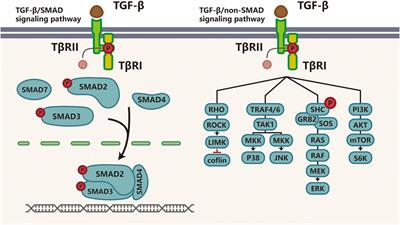

[TGF-β Signaling and Resistance to Cancer Therapy](https://www.frontiersin.org/articles/10.3389/fcell.2021.786728/full)

#### GEO dataset

In [8]:
gse = GEOparse.get_GEO("{YOUR_GSE_ID}")

01-Dec-2023 07:23:21 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
01-Dec-2023 07:23:21 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72419/soft/GSE72419_family.soft.gz to ./GSE72419_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72419/soft/GSE72419_family.soft.gz to ./GSE72419_family.soft.gz
100%|██████████| 3.44k/3.44k [00:00<00:00, 154kB/s]
01-Dec-2023 07:23:21 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
01-Dec-2023 07:23:21 DEBUG downloader - Moving /tmp/tmp6bt252b8 to /content/GSE72419_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp6bt252b8 to /content/GSE72419_family.soft.gz
01-Dec-2023 07:23:21 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72419/soft/GSE72419_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE724

In [9]:
cols = ['source_name_ch1',
        'characteristics_ch1.2.expression',
        'characteristics_ch1.3.treatment']

In [10]:
gse.phenotype_data.head(5)

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_zip/postal_code,contact_country,instrument_model,library_selection,library_source,library_strategy,relation,supplementary_file_1,series_id,data_row_count
GSM1862177,control shNS replicate 1,GSM1862177,Public on Oct 25 2016,Aug 26 2015,May 15 2019,SRA,1,Hela,Homo sapiens,9606,...,20892,USA,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE72419,0
GSM1862178,control shNS replicate 2,GSM1862178,Public on Oct 25 2016,Aug 26 2015,May 15 2019,SRA,1,Hela,Homo sapiens,9606,...,20892,USA,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE72419,0
GSM1862179,control shNS replicate 3,GSM1862179,Public on Oct 25 2016,Aug 26 2015,May 15 2019,SRA,1,Hela,Homo sapiens,9606,...,20892,USA,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE72419,0
GSM1862180,TGF-beta and EGF treated shNS replicate 1,GSM1862180,Public on Oct 25 2016,Aug 26 2015,May 15 2019,SRA,1,Hela,Homo sapiens,9606,...,20892,USA,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE72419,0
GSM1862181,TGF-beta and EGF treated shNS replicate 2,GSM1862181,Public on Oct 25 2016,Aug 26 2015,May 15 2019,SRA,1,Hela,Homo sapiens,9606,...,20892,USA,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE72419,0


In [11]:
keys = pd.read_csv(io.StringIO('''
GSM,SRR,SRX,Dataset
GSM1862177,SRR2130060,SRX1120818,GSE72419
GSM1862178,SRR2130061,SRX1120819,GSE72419
GSM1862179,SRR2130062,SRX1120820,GSE72419
GSM1862180,SRR2130063,SRX1120821,GSE72419
GSM1862181,SRR2130064,SRX1120822,GSE72419
GSM1862182,SRR2130065,SRX1120823,GSE72419
GSM1862183,SRR2130066,SRX1120824,GSE72419
GSM1862184,SRR2130067,SRX1120825,GSE72419
GSM1862185,SRR2130068,SRX1120826,GSE72419
GSM1862186,SRR2130069,SRX1120827,GSE72419
GSM1862187,SRR2130070,SRX1120828,GSE72419
GSM1862188,SRR2130071,SRX1120829,GSE72419
GSM1862189,SRR2130072,SRX1120830,GSE72419
GSM1862190,SRR2130073,SRX1120831,GSE72419
GSM1862191,SRR2130074,SRX1120832,GSE72419
GSM1862192,SRR2130075,SRX1120833,GSE72419
GSM1862193,SRR2130076,SRX1120834,GSE72419
GSM1862194,SRR2130077,SRX1120835,GSE72419
'''), header=0, index_col=0)

In [12]:
ann = pd.concat([gse.phenotype_data[cols], keys],
                axis = 1)
ann['condition'] = ann['characteristics_ch1.2.expression'] + ' + ' +  ann['characteristics_ch1.3.treatment']
ann.head(5)

,source_name_ch1,characteristics_ch1.2.expression,characteristics_ch1.3.treatment,SRR,SRX,Dataset,condition
GSM1862177,Hela,shNS,none,SRR2130060,SRX1120818,GSE72419,shNS + none
GSM1862178,Hela,shNS,none,SRR2130061,SRX1120819,GSE72419,shNS + none
GSM1862179,Hela,shNS,none,SRR2130062,SRX1120820,GSE72419,shNS + none
GSM1862180,Hela,shNS,TGF-beta and EGF,SRR2130063,SRX1120821,GSE72419,shNS + TGF-beta and EGF
GSM1862181,Hela,shNS,TGF-beta and EGF,SRR2130064,SRX1120822,GSE72419,shNS + TGF-beta and EGF


In [ ]:
#ann = load_example_data(modality="clinical")
#ann = pd.read_csv('ann.csv', index_col = 0)
#ann

### Control

In [13]:
len(ann.index) == len(exp.columns)

True

In [14]:
print(round(exp.sum().median()) == 1000000)
exp.sum()

True


SRR2130073    1000000.0
SRR2130062    1000000.0
SRR2130076    1000000.0
SRR2130064    1000000.0
SRR2130065    1000000.0
SRR2130063    1000000.0
SRR2130068    1000000.0
SRR2130071    1000000.0
SRR2130070    1000000.0
SRR2130072    1000000.0
SRR2130060    1000000.0
SRR2130069    1000000.0
SRR2130077    1000000.0
SRR2130067    1000000.0
SRR2130075    1000000.0
SRR2130074    1000000.0
SRR2130066    1000000.0
SRR2130061    1000000.0
dtype: float64

In [ ]:
len(exp.index) == 20062

True


If the number of genes is not equal to 20,062, check if it is TPMs or not. If it is not, delete the expression file and reload it. Unfortunately, sometimes the colab platform truncates large files. I regret :(
___
Если число генов не равно 20 062, проверь -- это TPMы или нет. Если нет -- удали файл с экспрессиями и загрузи заново. Увы :(
  Иногда коллаб срезает большие файлы

In [15]:
for col in ann.columns:
  print(f'{col}: ')
  for i,j in dict(ann[col].value_counts()).items():
    print(f' {i}\t{j}')

source_name_ch1: 
 Hela	18
characteristics_ch1.2.expression: 
 shNS	6
 shPCBP1	6
 shSmad3	6
characteristics_ch1.3.treatment: 
 TGF-beta and EGF	9
 none	6
 untreated	3
SRR: 
 SRR2130060	1
 SRR2130061	1
 SRR2130076	1
 SRR2130075	1
 SRR2130074	1
 SRR2130073	1
 SRR2130072	1
 SRR2130071	1
 SRR2130070	1
 SRR2130069	1
 SRR2130068	1
 SRR2130067	1
 SRR2130066	1
 SRR2130065	1
 SRR2130064	1
 SRR2130063	1
 SRR2130062	1
 SRR2130077	1
SRX: 
 SRX1120818	1
 SRX1120819	1
 SRX1120834	1
 SRX1120833	1
 SRX1120832	1
 SRX1120831	1
 SRX1120830	1
 SRX1120829	1
 SRX1120828	1
 SRX1120827	1
 SRX1120826	1
 SRX1120825	1
 SRX1120824	1
 SRX1120823	1
 SRX1120822	1
 SRX1120821	1
 SRX1120820	1
 SRX1120835	1
Dataset: 
 GSE72419	18
condition: 
 shNS + none	3
 shNS + TGF-beta and EGF	3
 shPCBP1 + none	3
 shPCBP1 + TGF-beta and EGF	3
 shSmad3 + untreated	3
 shSmad3 + TGF-beta and EGF	3


<font color="#e8851c">**Question**</font><br>
Describe what information is contained in the file **'ann.csv'**. What kind of data is it? How are they balanced? What results can be obtained? What biomarkers can be found out only with this data? What can be identified or predicted based on such data?
___
Опиши, какую информацию содержит файл **'ann.csv'**. Какого вида данные? Насколько они сбалансированы? Какие результаты можно получить? Какие биомаркёры можно найти имея только такие данные? Что можно определять или предсказывать только на основании таких данных?

<font color="#e8851c">**Task**</font><br>
In case of different number of patients between annotation data and expressions data, you can try writing a simple code to make the dataframes have an equal number of rows. There may be extra samples, annotations, logged expressions, and NaN-values. You have to check and filter out.
___
Если аннотация и экспрессии содержат разное количество пациентов -- попробуй написать простой код, чтобы таблицы содержали имели равное число строк. Могут быть лишние пациенты, аннотация, отлогарифмированные экспрессии, NaN-значения -- нужно проверить и отфильтровать

## Let's go!

You have to create an object of the 'PydeseqCohort' class, specifying the expression and annotation files during initialization. Come up with a name for your cohort and write it to the 'cohort_name' variable. For example: <br>
cohort_name = "My_name's homework N5"
___
Тебе нужно создать объект класса 'PydeseqCohort' и загрузить в него экспрессии и аннотацию при инициализации самого объекта. Также нужно придумать название когорты и записать в переменную 'cohort_name'.

In [16]:
cohort_name = 'Example'

In [17]:
cohort = PydeseqCohort(counts.T,
                       ann,#.set_index('SRX'),
                       cohort = cohort_name)
cohort

PydeseqCohort(cohort='Example')

Here you are going to run the PyDESeq2 algorithm for your cohort. For this, you have to specify three string variables: 'run_name', 'design_factor', 'reference_level'.
1. **'run_name'** is the name of your dry experiment. For example, if you are comparing tumour vs normal, you can write "T/N".
2. **'design_factor'** is the name of the column in your annotation file that you are analyzing. For example, "Diagnosis" or "Histology".
3. **'reference_level'** is one of the values in the 'design_factor' column, against which DEA is performed.

In [18]:
run_name = '{Short name}'   #For example
design_factor = 'condition'  #Your column name
reference_level = 'shNS + none' #Your category
tested_level = 'shNS + TGF-beta and EGF'

In [19]:
cohort.run_pydeseq(run_name, #design_factor, reference_level,
                   contrast=[design_factor, tested_level, reference_level],
                   n_cpus=1)

There are 18 samples with annotation

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 91.79 seconds.

Fitting dispersion trend curve...
... done in 7.59 seconds.

Fitting MAP dispersions...
... done in 95.24 seconds.

Fitting LFCs...
... done in 20.02 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.82 seconds.

Log2 fold change & Wald test p-value: condition shNS + TGF-beta and EGF vs shNS + none


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
A1BG,1.611328,-1.500488,2.577032,-0.582254,5.603956e-01,NaN
A1CF,72.033671,1.274010,0.499398,2.551093,1.073856e-02,3.584473e-02
A2M,591.838891,-7.932865,0.486329,-16.311740,8.143961e-60,2.165051e-57
A2ML1,11.639319,-3.322677,0.880117,-3.775265,1.598376e-04,9.011694e-04
A3GALT2,10.162927,-0.615861,0.663448,-0.928274,3.532657e-01,5.455990e-01
...,...,...,...,...,...,...
ZYG11B,2759.380217,-0.166638,0.169599,-0.982546,3.258307e-01,5.159441e-01
ZYX,21504.124978,0.981695,0.321942,3.049286,2.293860e-03,9.594452e-03
ZZEF1,4326.855721,-0.111845,0.218246,-0.512473,6.083198e-01,7.691034e-01


<ipython-input-4-eb95cbd03e97>:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-4-eb95cbd03e97>:513: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 2. Volcanoplot
>The volcano plot is a graphical method commonly used in the field of genomics and bioinformatics to display the results of differential expression analysis (DEA) between two groups of biological samples. It provides a visual representation of the statistical significance and magnitude of changes in gene expression between the two groups.

>The plot is typically generated by plotting the negative logarithm (base 10) of the p-values (significance levels) of each gene against the logarithm (base 2) of the fold change (difference in expression levels) between the two groups. The resulting plot is a scatterplot with each gene represented by a dot. The position of the dot on the plot represents the statistical significance (p-value) of the gene's differential expression, with dots higher up on the plot being more significant. The horizontal position of the dot represents the magnitude of the differential expression, with dots farther to the left or right indicating greater fold changes.

>The name "volcano plot" comes from the volcano-like shape of the plot, which is formed by the pattern of dots on the plot. The top of the plot represents genes with the highest statistical significance, while the left and right sides of the plot represent genes with the largest fold changes.

>Volcano plots are commonly used in genomics and bioinformatics research to identify differentially expressed genes that are statistically significant and biologically relevant. They can be used to identify candidate genes for follow-up experiments, to identify gene sets or pathways that are enriched for differentially expressed genes, and to identify potential biomarkers for disease diagnosis or prognosis.

>In summary, the volcano plot is a widely used visualization tool in genomics and bioinformatics that provides a concise and informative way to display the results of differential expression analysis between two groups of biological samples. It shows the significance and magnitude of changes in gene expression and can help identify biologically relevant genes and pathways.

## Volcanoplot. Plotly

In [ ]:
cohort.volcanoplot(run_name, use_module = 'go')

## Volcanoplot. **Matplotlib**
Choose three genes: upregulated, not significant, downregulated and write it down in three variables. Choose your threshold for your volcanoplot.
___
Выбери три гена: с повышенною экспрессией, не значимою, низкою, и запиши в три переменные. Подбери свои условия для вулканоплота.

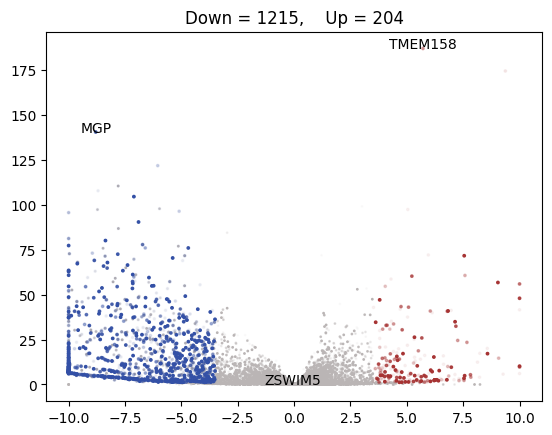

<Figure size 800x800 with 0 Axes>

In [ ]:
gene1, gene2, gene3 = 'up', 'another', 'down'
cohort.volcanoplot(run_name, genes = [gene1, gene2, gene3], significance = (0.06, #p-value
                                                                            3.5,  #log2fc
                                                                            0.17  #p-adj
                                                                            ),
                   clip=10)
plt.show()

<font color="#e8851c">**Question**</font><br>
What is the difference between plotly and matplotlib packages? What are the potential advantages and disadvantages? Did you notice any pattern on the chart? Any feature?
___
Чем отличаются графики пакетов plotly и matplotlib? Какие могут быть преимущества и недостатки? Заметил(а) ли ты какую-нибудь закономерность на графике? Какую-либо особенность?

# Student's t-test

In [29]:
import scipy.stats as stats

condition_A, condition_B = 'A', 'B'

sample1 = exp.loc[gene1][ann.loc[ann.condition == condition_A].SRR]
sample2 = exp.loc[gene1][ann.loc[ann.condition == condition_B].SRR]

# Независимый t-тест
t_stat, p_value = stats.ttest_ind(sample1, sample2)
print(f"T-статистика: {t_stat}, p-value: {p_value}")

T-статистика: 15.088020680348997, p-value: 0.0001124630220919799


# 3. Mann-Whitney U test
>The Mann-Whitney test is a statistical test used to compare two independent groups of samples
    when the assumptions of normality and equal variances are not met. It is a non-parametric test,
    which means that it does not rely on the normal distribution of the data, but rather on their rank order.

>To put it simply, the Mann-Whitney test determines whether the two groups of samples
    come from the same distribution or not.
    It does this by comparing the sum of the ranks of the samples in each group. If the sums are similar,
    then the samples are likely to come from the same distribution. If the sums are significantly different,
    then the samples are likely to come from different distributions.

>The test is named after its creators, Frank Wilcoxon and Henry Mann.
    It is also sometimes called the Wilcoxon rank-sum test or the Wilcoxon-Mann-Whitney test.
    The Mann-Whitney test is widely used in many fields, including biology, psychology, and economics.

## Boxplots with p-value

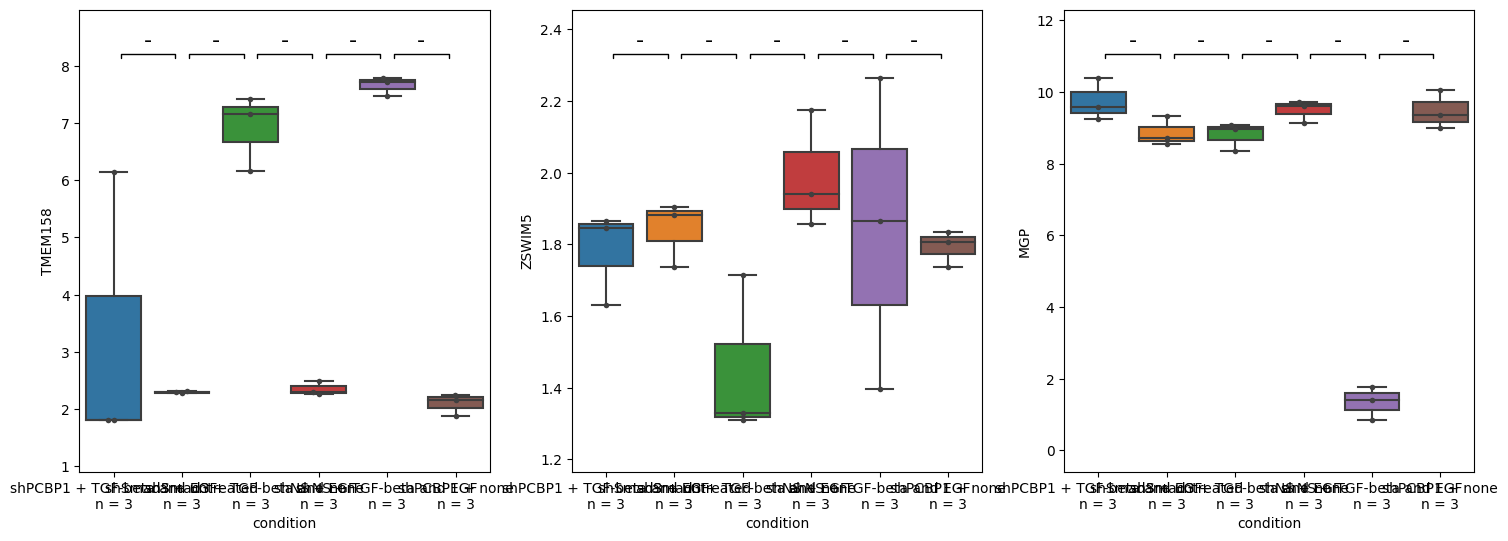

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                         sharex = False, sharey = False)
#ann = ann.set_index('SRR')
indices = ann.index & exp.T.index

boxplot_with_pvalue_2(data = np.log2(1+exp.T[gene1]).loc[indices],
                      grouping = ann[design_factor].loc[indices],
                      ax = axes[0], s = 4,)
boxplot_with_pvalue_2(data = np.log2(1+exp.T[gene2]).loc[indices],
                      grouping = ann[design_factor].loc[indices],
                      ax = axes[1], s = 4,)
boxplot_with_pvalue_2(data = np.log2(1+exp.T[gene3]).loc[indices],
                      grouping = ann[design_factor].loc[indices],
                      ax = axes[2], s = 4,)
plt.show()

<font color="#e8851c">**Question**</font><br>
What do you see? Does the test result match the DE analysis? Why?
___
Что ты видишь? Результаты теста сходятся с DE-анализом? Почему?

## Let's compare DE and Mann-Whitney
Select the values of *p_value*, *p_adj*, and *log2fc* that will result in approximately 50-100 DE genes remaining.
___
Подбери такие условия *p_value*, *p_adj*, и *log2fc*, чтобы осталось примерно 50-100 дифференциально экспрессированных генов


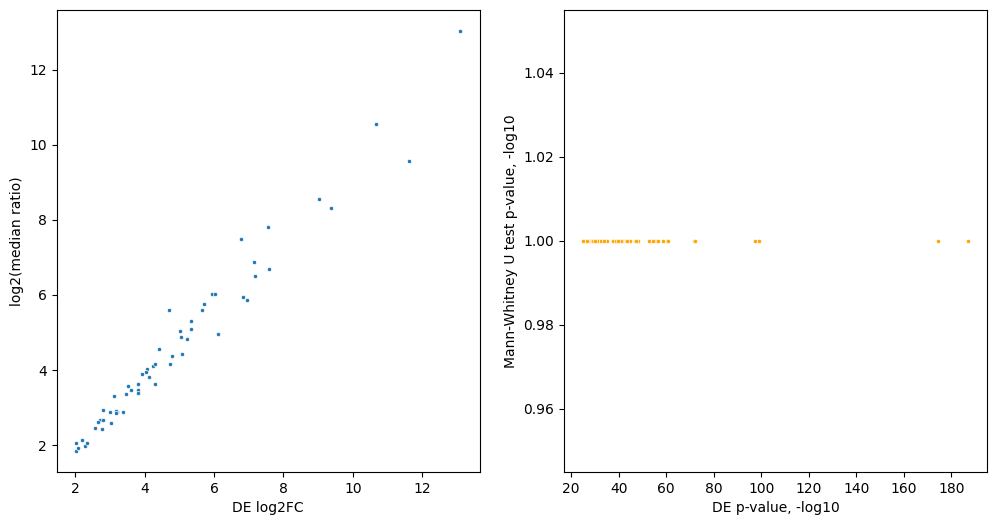

In [ ]:
from numpy import log10 as lg
upregulated = cohort.upregulated_genes(run_name,
                          p_value = 1e-25, # <---------|
                          p_adj = 1e-20,   # <---------|
                          log2fc = 2)      # <---------|

base = ann.loc[ann[design_factor] == reference_level].index
comparison = ann.loc[ann[design_factor] == tested_level].index

fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                         sharex = False, sharey = False)
sns.scatterplot(x = cohort.pydeseq_results[run_name].loc[upregulated].log2FoldChange,
                y = np.log2(exp.T[upregulated].loc[comparison].median()/
                            exp.T[upregulated].loc[base].median()), marker = '.', ax = axes[0])
axes[0].set_ylabel('log2(median ratio)')
axes[0].set_xlabel('DE log2FC')

sns.scatterplot(x = (-1)*cohort.pydeseq_results[run_name].loc[upregulated].pvalue.apply(lg),
                y = [-lg(mannwhitneyu(x = exp.T[i].loc[comparison],
                                      y = exp.T[i].loc[base])[1]) for i in upregulated],
                marker = '.', ax = axes[1], color = 'orange')
axes[1].set_ylabel('Mann-Whitney U test p-value, -log10')
axes[1].set_xlabel('DE p-value, -log10')
plt.show()

<font color="#e8851c">**Question**</font><br>
What mathematical functions are your results approximated to (What algebraic graphs do they resemble)?  How can it be explained?
___
На какие математические функции аппроксимируются твои результаты? (На какие алгебрические графики похожи?) Чем это можно объяснить?

# **4. Enrichment analysis**



*   Количественно: [Systems Biomedicine - Julio Saez-Rodriguez's group](https://github.com/saezlab)
*   Качественно: [STRING-DB](https://string-db.org/) Protein-Protein Interaction Networks,
Functional Enrichment Analysis

### *Количественно*

#### PROGENy
>PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 100 responsive genes ranked by p-value. Here is a brief description of each pathway:

* Androgen: involved in the growth and development of
the male reproductive organs.

* EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

* Estrogen: promotes the growth and development of the female reproductive organs.

* Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

* JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.

* MAPK: integrates external signals and promotes cell growth and proliferation.

* NFkB: regulates immune response, cytokine production and cell survival.

* p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

* PI3K: promotes growth and proliferation.

* TGFb: involved in development, homeostasis, and repair of most tissues.

* TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

* Trail: induces apoptosis.

* VEGF: mediates angiogenesis, vascular permeability, and cell migration.

* WNT: regulates organ morphogenesis during development and tissue repair.

0.00B [00:00, ?B/s]

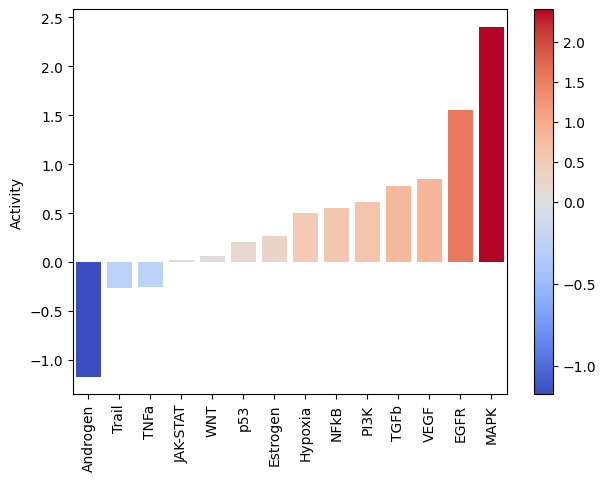

In [ ]:
cohort.get_progeny(run_name)

<font color="#e8851c">**Question**</font><br>
What pathways are active in the tumor? What could explain this? What advantages could this give to the tumor?
___
Какие пути активны в опухоли? Чем это можно объяснить? Какие преимущества это может давать опухоли?

#### **LIANA**
Enrichment of ligand-receptor interactions.


>Recently, study of interactions between ligands and receptors have
        gained significant traction, notably pushed by
        the democratization of single cell sequencing technologies.
        While most methods (such as the one described in LIANA) are developed for
        single cell datasets, they rely on a relatively simple assumption of co-expression or
        co-regulation of two (or more in the context of complexes) genes acting as
        ligand and receptors to propose hypothetical ligand-receptor interaction events.
        This concept can seamlessly be applied to a bulk RNA dataset,
        where the assumption is that sender and receiver cells are convoluted in a single dataset,
        but the observation of significant co-regulation of ligand and
        receptors should still correspond to hypothetical ligand-receptor interaction events.

>At the core, most current ligand-receptor interaction methods
        rely on averaging the measurements obtained for ligand and receptor and
        standardizing them against a background distribution.
        Thus, an enrichment method based on a weighted mean can emulate this,
        where the sets are simply the members of a ligand receptor pair
        (or more in the context of complexes).

>Thus, we can extract ligand-receptor interaction ressources from the LIANA package
        (available both in R and python), and use it as a prior knowledge network with decoupler
        to find the most significant pairs of ligand-receptors in a given bulk dataset.

>While more work is required to fully understand the functional relevance of
        the highlighted ligand-receptor interactions with such an approach,
        this represents a very straightforward and intuitive approach to embed a bulk RNA dataset
        with ligand-receptor interaction prior knowledge.

>First, we extract ligand-receptor interactions from liana,
        and decomplexify them to format them into an appropriate decoupleR input.

[Read more](https://liana-py.readthedocs.io/en/latest/index.html)

(              A2M|LRP1 AANAT|MTNR1A AANAT|MTNR1B ACE|AGTR2 ACE|BDKRB2  \
 {Short name} -2.997351    -0.013192     0.126379 -0.621462  -1.525639   
 Ligand             A2M        AANAT        AANAT       ACE        ACE   
 Receptor          LRP1       MTNR1A       MTNR1B     AGTR2     BDKRB2   
 
              ACTR2|ADRB2 ACTR2|LDLR ACTR2|LRP2 ADAM10|AXL ADAM10|CADM1  ...  \
 {Short name}    1.787178   2.231198   0.912334   2.491285     0.629987  ...   
 Ligand             ACTR2      ACTR2      ACTR2     ADAM10       ADAM10  ...   
 Receptor           ADRB2       LDLR       LRP2        AXL        CADM1  ...   
 
              XCL2|XCR1 YBX1|NOTCH1 ZG16B|CXCR4 ZG16B|TLR2 ZG16B|TLR4  \
 {Short name}  0.041962    0.261435     1.28975   0.427407   1.800589   
 Ligand            XCL2        YBX1       ZG16B      ZG16B      ZG16B   
 Receptor          XCR1      NOTCH1       CXCR4       TLR2       TLR4   
 
              ZG16B|TLR5 ZG16B|TLR6 ZP3|CHRNA7  ZP3|EGFR ZP3|MERTK  
 {Short name}  -1

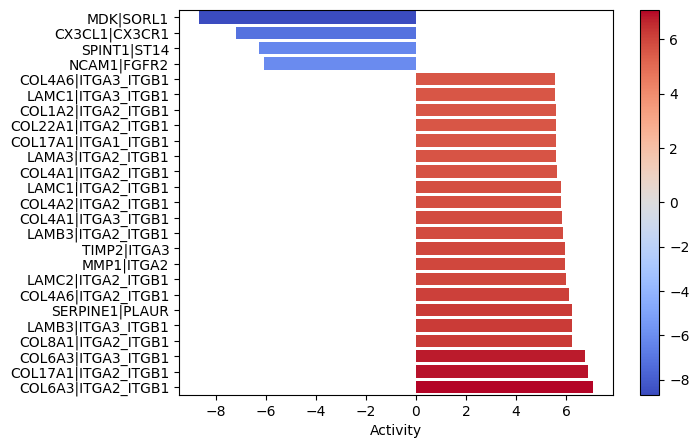

In [ ]:
activity, p_values = cohort.liana_enrichment(run_name, return_result=True)

<font color="#e8851c">**Question**</font><br>
What ligand-receptor pairs are active in the tumor? What could explain this? What advantages could this give to the tumor?
___
Какие лигандо-рецепторные активны в опухоли? Чем это можно объяснить? Какие преимущества это может давать опухоли?

#### **DoRothEA**
Transcription factor activity inference.
> Similarly to pathways, we can estimate transcription factor activities using the resource DoRothEA and the consensus method.<br>
[Read more](https://saezlab.github.io/dorothea/)





0.00B [00:00, ?B/s]

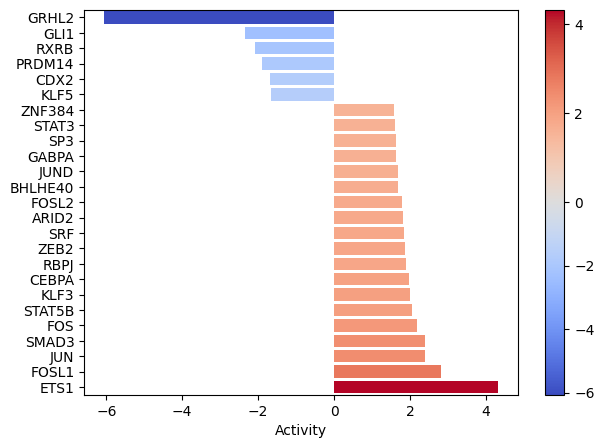

In [ ]:
cohort.dorothea_enrichment(run_name)

<font color="#e8851c">**Question**</font><br>
What transcription factors/regulomes are active in the tumor? What could explain this? What advantages could this give to the tumor?
___
Какие транскрипционные факторы/регуломы активны в опухоли? Чем это можно объяснить? Какие преимущества это может давать опухоли?

### *Качественно*

#### HPA
>The open access resource for human proteins. Search for specific genes/proteins or explore the 12 different sections.
[The Human Protein Atlas](https://www.proteinatlas.org/)

In [ ]:
result = cohort.HPA_enrichment(run_name, log2fc = 6, p_value = .0017)

0.00B [00:00, ?B/s]

ChunkedEncodingError: ignored

In [ ]:
result

<font color="#e8851c">**Question**</font><br>
Choose your diagnosis. What have you found interesting? Describe your findings. Сheck your findings on [The Human Protein Atlas](https://www.proteinatlas.org/) and attach a screenshot.
___
Выбери свой диагноз. Что интересного нашлось? Опиши свои находки, проверь на сайте атласа и добавь скриншот

#### STRING-DB
>STRING (Search Tool for the Retrieval of Interacting Genes/Proteins)
    is a biological database and web resource of known and predicted protein–protein interactions.

>The STRING database contains information from numerous sources, including experimental data,
    computational prediction methods and public text collections.
    It is freely accessible and it is regularly updated.
    The resource also serves to highlight functional enrichments in user-provided lists of proteins,
    using a number of functional classification systems such as GO, Pfam and KEGG.
    The latest version 11b contains information on about 24,5 million proteins from more than 5000 organisms.
    STRING has been developed by a consortium of academic institutions including CPR, EMBL, KU, SIB, TUD and UZH.
[Read more](https://string-db.org/)

In [ ]:
result = cohort.enrichment_analysis(run_name, log2fc = 0)
result.query('number_of_genes <= 36')

,category,term,number_of_genes,number_of_genes_in_background,ncbiTaxonId,inputGenes,preferredNames,p_value,fdr,description,gene_percent
944,RCTM,HSA-1650814,30,67,9606,"PLOD1,PLOD3,P3H1,COLGALT1,COL8A1,P4HA1,COL5A3,...","PLOD1,PLOD3,P3H1,COLGALT1,COL8A1,P4HA1,COL5A3,...",9.760000e-07,0.00022,Collagen biosynthesis and modifying enzymes,0.447761
282,Process,GO:0007229,36,100,9606,"FERMT1,PLEK,ADAM10,ITGAV,SEMA7A,TXK,NRP1,ITGA1...","FERMT1,PLEK,ADAM10,ITGAV,SEMA7A,TXK,NRP1,ITGA1...",5.200000e-06,0.00039,Integrin-mediated signaling pathway,0.360000
294,Process,GO:1903053,25,56,9606,"TNFRSF1A,FAP,TGFB1,LAMB1,AEBP1,ADTRP,LRP1,COLG...","TNFRSF1A,FAP,TGFB1,LAMB1,AEBP1,ADTRP,LRP1,COLG...",7.930000e-06,0.00057,Regulation of extracellular matrix organization,0.446429
1155,HPO,HP:0004334,33,88,9606,"ERCC1,B4GALT7,PLOD1,FERMT1,FKBP14,AEBP1,CTSC,L...","ERCC1,B4GALT7,PLOD1,FERMT1,FKBP14,AEBP1,CTSC,L...",6.350000e-06,0.00061,Dermal atrophy,0.375000
947,RCTM,HSA-2022090,27,61,9606,"LOX,PXDN,COL8A1,LOXL1,LAMC2,COL5A3,COL6A3,COL6...","LOX,PXDN,COL8A1,LOXL1,LAMC2,COL5A3,COL6A3,COL6...",3.960000e-06,0.00070,Assembly of collagen fibrils and other multime...,0.442623
...,...,...,...,...,...,...,...,...,...,...,...
931,PMID,PMID:34095157,30,66,9606,"PLOD1,TIMP1,FKBP14,PLOD3,LOX,P3H1,COLGALT1,TIM...","PLOD1,TIMP1,FKBP14,PLOD3,LOX,P3H1,COLGALT1,TIM...",7.630000e-07,0.04790,"(2021) Collagen Biosynthesis, Processing, and ...",0.454545
1420,HPO,HP:0007495,35,136,9606,"ERCC1,SNAI2,B4GALT7,PLOD1,USB1,OBFC1,ATP6V1E1,...","ERCC1,SNAI2,B4GALT7,PLOD1,USB1,STN1,ATP6V1E1,G...",1.600000e-03,0.04810,Prematurely aged appearance,0.257353
933,PMID,PMID:22300531,32,74,9606,"IL1RL1,EGR1,EGR2,FOSB,OASL,IL1A,IL1B,FGF2,SLC3...","IL1RL1,EGR1,EGR2,FOSB,OASL,IL1A,IL1B,FGF2,SLC3...",7.860000e-07,0.04850,(2012) Differences in gene expression and cyto...,0.432432
985,RCTM,HSA-5210891,8,11,9606,"MAP2K2,ANTXR1,MAP2K1,ANTXR2,MAP2K3,MAP2K7,PDCD...","MAP2K2,ANTXR1,MAP2K1,ANTXR2,MAP2K3,MAP2K7,PDCD...",1.100000e-03,0.04850,Uptake and function of anthrax toxins,0.727273


<font color="#e8851c">**Question**</font><br>
Check your findings on [GO](http://geneontology.org/), [STRING-DB](https://string-db.org/) and [KEGG](http://geneontology.org/).
What do this processes mean? Probably, you should filter your result: genes ~ 6-36; low p-value/fdr. And attach a screenshot.
___

Проверь свои находки на портале GO, STRING и KEGG. Что это значит для опухоли? Скоре всего нужно отфильтровать результаты по числу генов и FDR. И добавь скрины того, что нашлось.

# 5. ssGSEA

In [35]:
gmt = {
'CAF': GeneSet(
    name='CAF', descr='Fibroblasts',
    genes=['COL6A2', 'CD248', 'FGF2', 'LRP1', 'COL6A1', 'FAP', 'MFAP5',
           'COL1A2', 'MMP3', 'ACTA2', 'COL6A3', 'PDGFRA', 'COL1A1', 'COL5A1',
           'PDGFRB', 'MMP2', 'FBLN1', 'CXCL12', 'LUM']),
'EMT_signature': GeneSet(
    name='EMT_signature', descr='EMT signature',
    genes=['SNAI1', 'TWIST2', 'TWIST1', 'ZEB1', 'CDH2', 'ZEB2', 'SNAI2']),
}

result = ssgsea_formula(exp, gmt).T